# Investigate simulations with individual soil column per pft  

Inlcuding regridding

(c) Inne Vanderkelen - October 2023

## 1. Settings

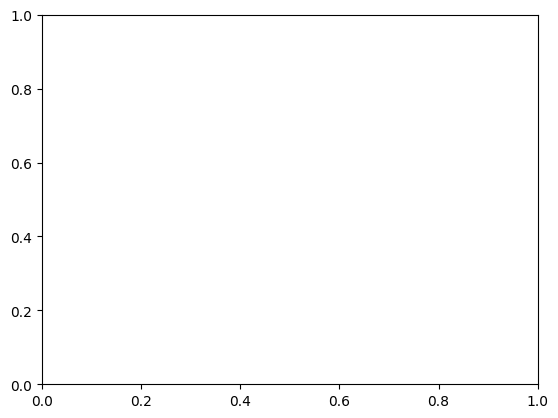

In [1]:
# laod modules 
import xarray as xr
import matplotlib.pyplot as plt
import os
import regionmask 
import pandas as pd

# import own utils module
from iv_utils_daint import *
from ctsm_py.utils import  * #info on ctsm utils: https://github.com/NCAR/ctsm_python_gallery 

# do plotting settings
set_plot_param()

# ignore all runtime warnings
warnings.filterwarnings('ignore')

In [2]:
# directory settings

# set directories
outdir = '/scratch/snx3000/ivanderk/'

# Define directory where processing is done 
procdir =  outdir + 'processing_4p1000/' 

# go to processing directory 
os.chdir(procdir)

In [3]:
# case settings

# define scenario
scenario = 'high'

# case settings
case_ctl = 'IHistClm51Sp.hcru_hcru_mt13.pftsoilcol.CTL.spunup'
case_scen = 'IHistClm51Sp.hcru_hcru_mt13.pftsoilcol.'+scenario+'.spunup2'

case   = case_ctl
block  = 'lnd' 
stream = 'h1' 

# List of variables to import from file(s) in $indir matching $pattern.
variables = ['H2OSOI',"TOTSOILLIQ","TOTSOILICE", "QINFL" , "QOVER", "QDRAI", 'EFLX_LH_TOT',  "watsat","QROOTSINK" ,"QVEGE", "QVEGT","QSOIL",
             "watfc", "EFF_POROSITY", ] #"SOILPSI", "FPSN","QHR","SMP","GSSHA","GSSUN"

# discard 2004 until 2008 as spin up years
start_year, end_year = 1995, 2014 

time_slice = slice(str(start_year)+"-01-01", str(end_year)+"-12-01")

In [4]:
## settings for plotting
ds_ctl =  load_case_ctl(['H2OSOI'])

# get mask and region ids
exclude_ids = np.array([0,1,2,16,28,29,30,31])
mask_regions = regionmask.defined_regions.ar6.land.mask(ds_ctl['H2OSOI'])

region_ids = np.arange(0,44)
region_ids = np.delete(region_ids, exclude_ids)

regions_sand_clay = [6, 7, 10, 11, 12, 14, 19, 21, 22, 23, 24, 26, 37, 38, 39, 41]

plotting_depth = 2 # m 8
figsize = (17,38)

In [5]:
# get pfts modelled - bare soil, grassland and crop pfts
pft_list_crops = [15,16]
pft_list_grassland = [0,12,13,14]

### Load auxiliary data (soil levels, input dataset, wilting point etc) 

In [6]:
# info on soil levels
# manually get soil level info from CLM
levsoi_thickness, levsoi_depth, levgrnd_thickness , levgrnd_depth = get_soildepths()

# get info on soil levels
levsoi = ds_ctl['levsoi'].values
levgrnd = ds_ctl['levgrnd'].values # all soil layers (deepest 5 layers are for thermodynamical calculations)

In [7]:
# input data
# define variables to load from input dataset
input_variables = ['ORGANIC','PFTDATA_MASK','PCT_SAND','PCT_CLAY']

# load inputdata
ds_input, ds_input_scen, landmask = load_inputdata('CTL', input_variables, case_ctl)
ds_input_scen, ds_input_scen, landmask = load_inputdata(scenario, ['ORGANIC', 'PFTDATA_MASK'], case_scen)

In [19]:
%%time 

def calc_gridcell_means(variables, pft_int, lat_cell, lon_cell):
    d_ctl_cell = {}
    d_scen_cell = {}
    d_delta_cell = {}


    for variable in variables: 
        print('loading grid cell values of '+variable)

        case_ctl = 'IHistClm51Sp.hcru_hcru_mt13.pftsoilcol.CTL.spunup2'

        da_pft_ctl = load_da_gridded_pft(variable, pft_int, case_ctl)
        da_pft_ctl_cell = da_pft_ctl.rename(variable).sel(lat=lat_cell,lon=lon_cell).squeeze().mean('time')

        if 'levgrnd' in da_pft_ctl_cell.dims: 
            da_pft_ctl_cell = da_pft_ctl_cell.rename({'levgrnd':'levsoi'}).isel(levsoi=range(0,len(levsoi_depth)))


        for scenario in ['high','4p1000','medium']: 
            # define scenario
            case_scen = 'IHistClm51Sp.hcru_hcru_mt13.pftsoilcol.'+scenario+'.spunup2'

            da_pft_scen = load_da_gridded_pft(variable, pft_int, case_scen)
            da_pft_scen_cell = da_pft_scen.rename(variable).sel(lat=lat_cell,lon=lon_cell).squeeze().mean('time')

            if 'levgrnd' in da_pft_scen_cell.dims: 

                da_pft_scen_cell = da_pft_scen_cell.rename({'levgrnd':'levsoi'}).isel(levsoi=range(0,len(levsoi_depth)))


            da_delta = (da_pft_scen_cell - da_pft_ctl_cell)

            d_ctl_cell[variable] = da_pft_ctl_cell
            d_scen_cell[variable+'_'+scenario] = da_pft_scen_cell
            d_delta_cell[variable+'_'+scenario] = da_delta

    return d_ctl_cell, d_scen_cell, d_delta_cell
        
        
        

CPU times: user 8 µs, sys: 0 ns, total: 8 µs
Wall time: 11.7 µs


In [20]:
def plot_abs_profiles(variables, d_xlims, d_ctl_cell, d_scen_cell, marker, d_units): 

    # plot difference profiles for water content, soil matric potential and root water uptake. 
    fig, axes = plt.subplots(1,3,figsize=(10,6))
    axes = axes.flatten()

    for i, variable in enumerate(variables): 

        ax = axes[i]

        ax.plot(d_ctl_cell[variable], levsoi[:len(d_ctl_cell[variable].levsoi.values)], marker='.', color='k', label='CTL')
        for scenario in ['high','4p1000','medium']:    

            ax.plot(d_scen_cell[variable+'_'+scenario] , levsoi[:len(d_ctl_cell[variable].levsoi.values)], marker='.',  label = scenario, alpha=0.75,)

        ax.set_ylabel('Soil layer depth (m)'); 
        ax.set_xlabel(variable + ' ' +str(d_units[variable])); 
        for depth in levsoi_depth:
            ax.axhline(depth,  color='grey', alpha=0.2)
        ax.vlines(0, max(levgrnd_depth),0, color='grey', alpha=0.5)
        if not d_xlims[variable] == False: 
            ax.set_xlim([d_xlims[variable][0],d_xlims[variable][1]])
        ax.set_yticks(levsoi_depth)
        ax.set_ylim([1.8,0]); 
        ax.legend(frameon=False)
        ax.set_title(variable +' '+marker, loc='right' );

    fig.tight_layout()

In [21]:
# plot difference profiles for water content, soil matric potential and root water uptake. 

def plot_delta_profiles(variables, d_xlims, d_delta_cell, marker, d_units): 

    fig, axes = plt.subplots(1,3,figsize=(10,6))
    axes = axes.flatten()


    for i, variable in enumerate( variables): 

        ax = axes[i]

        for scenario in ['high','4p1000']:    

            ax.plot(d_delta_cell[variable+'_'+scenario] , levsoi[:len(d_delta_cell[variable+'_'+scenario] .levsoi.values)], marker='.',  label = scenario, alpha=0.75,)

        ax.set_ylabel('Soil layer depth (m)'); 

        for depth in levsoi_depth:
            ax.axhline(depth,  color='grey', alpha=0.2)
        ax.vlines(0, max(levgrnd_depth),0, color='grey', alpha=0.5)

        if not d_xlims[variable] == False: 
            ax.set_xlim([d_xlims[variable][0],d_xlims[variable][1]])
        ax.set_xlabel(variable + ' ' +str(d_units[variable])); 

        ax.set_yticks(levsoi_depth)
        ax.set_ylim([1.8,0]); 
        ax.legend(frameon=False, loc='lower right')
        ax.set_title('$\Delta$ '+variable +' '+marker, loc='right' );

    fig.tight_layout()

In [11]:
variables = ["H2OSOI", "SMP", "QROOTSINK"]

d_units = {'H2OSOI': 'mm3/mm3', 'SMP' : 'mm', 'QROOTSINK' : 'mm/s'}


## Look at gridcell profiles

### NANYUKI

In [12]:
# select single grid cell to plot
lat_cell = 0.25
lon_cell = 37.25
marker   = 'Nanyuki'
pft_int = pft_list_crops[0]

In [22]:
d_ctl_cell, d_scen_cell, d_delta_cell = calc_gridcell_means(variables, pft_int, lat_cell, lon_cell)

loading grid cell values of H2OSOI
loading grid cell values of SMP
loading grid cell values of QROOTSINK


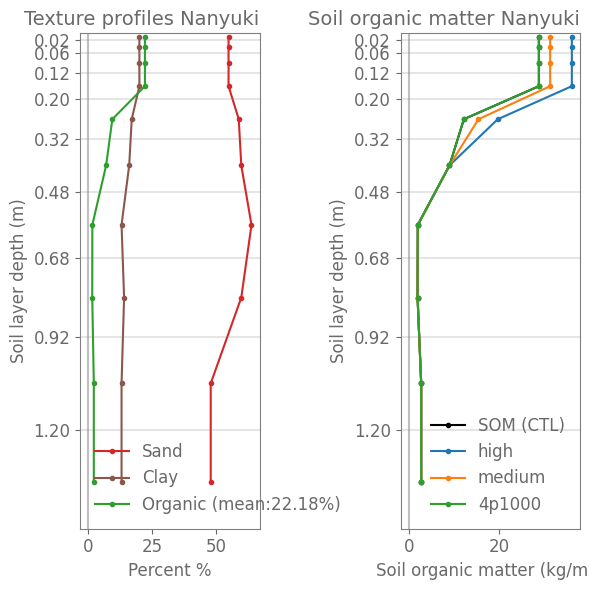

In [23]:
# plot difference profiles for water content, soil matric potential and root water uptake. 
pct_sand = ds_input['PCT_SAND'].sel(lat=lat_cell,lon=lon_cell)
pct_clay = ds_input['PCT_CLAY'].sel(lat=lat_cell,lon=lon_cell)
pct_organic = ds_input['ORGANIC'].sel(lat=lat_cell,lon=lon_cell)


fig, axes = plt.subplots(1,2,figsize=(6,6))

ax=axes[0]
ax.plot(pct_sand, levsoi[:len(pct_sand.nlevsoi.values)], marker='.', color='tab:red', label='Sand')
ax.plot(pct_clay, levsoi[:len(pct_sand.nlevsoi.values)], marker='.', color='tab:brown', label='Clay')
rel_pct_organic = (pct_organic / 130)*100
organic_label= 'Organic (mean:'+str(np.round(rel_pct_organic[0].values, 2))+'%)'
ax.plot(rel_pct_organic, levsoi[:len(pct_sand.nlevsoi.values)], marker='.', color='tab:green', label=organic_label)

ax.set_ylabel('Soil layer depth (m)'); 
ax.set_xlabel('Percent %')   
for depth in levsoi_depth:
    ax.axhline(depth,  color='grey', alpha=0.2)
ax.vlines(0, max(levgrnd_depth),0, color='grey', alpha=0.5)
#ax.set_xlim([50,100])
ax.set_yticks(levsoi_depth)
ax.set_ylim([1.5,0]); 
ax.legend(frameon=False)
ax.set_title('Texture profiles '+marker, loc='right' );

ax=axes[1]

ax.plot(pct_organic, levsoi[:len(pct_sand.nlevsoi.values)], marker='.',color = 'k',  label='SOM (CTL)')

# load for lat and lons
ds_lonlat = import_case(case_ctl, myVars=['TWS'], timeSlice=slice(str(start_year)+"-01-01", str(start_year)+"-02-01"), alter_lons=False)

for scenario in ['high','medium','4p1000']: 
    
    inputdir = procdir+'surfdata_4p1000/'
    ds_input = import_ds(inputdir+'surfdata_360x720cru_16pfts_Irrig_CMIP6_simyr2000_c170824_'+scenario+'.nc', myVars=input_variables,rename_lsmlatlon=True)

    # adapt lons and lats
    ds_input['lon'] = ds_lonlat['lon']
    ds_input['lat'] = ds_lonlat['lat']

    ds_input = lon_pm2idl(ds_input)
    
    pct_organic_scen = ds_input['ORGANIC'].sel(lat=lat_cell,lon=lon_cell)
    ax.plot(pct_organic_scen, levsoi[:len(pct_sand.nlevsoi.values)], marker='.', label=scenario)

ax.set_ylabel('Soil layer depth (m)'); 
ax.set_xlabel('Soil organic matter (kg/m3)')   
for depth in levsoi_depth:
    ax.axhline(depth,  color='grey', alpha=0.2)
ax.vlines(0, max(levgrnd_depth),0, color='grey', alpha=0.5)
#ax.set_xlim([50,100])
ax.set_yticks(levsoi_depth)
ax.set_ylim([1.5,0]); 
ax.legend(frameon=False)
ax.set_title('Soil organic matter '+marker, loc='right' );

fig.tight_layout()


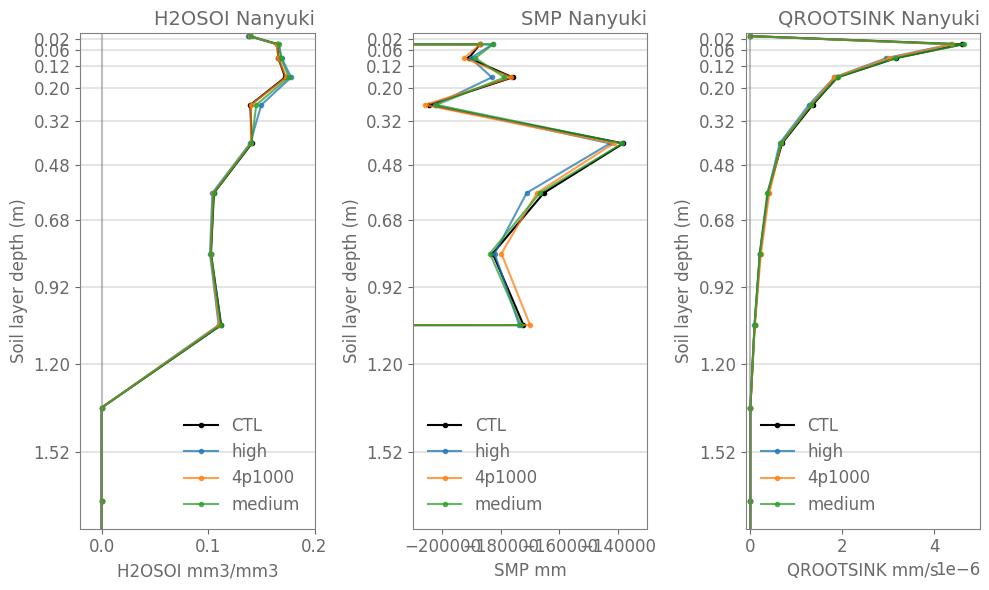

In [24]:
d_xlims = {'H2OSOI': [-0.02,0.2], 'SMP' : [-0.21e6,-0.13e6], 'QROOTSINK' : [-1e-7, 5e-6]}

plot_abs_profiles(variables, d_xlims, d_ctl_cell, d_scen_cell, marker, d_units)

In [ ]:
d_xlims = {'H2OSOI': [-0.02,0.2], 'SMP' : [-0.21e6,-0.13e6], 'QROOTSINK' : [-1e-7, 5e-6]}

plot_abs_profiles(variables, d_xlims, d_ctl_cell, d_scen_cell, marker, d_units)

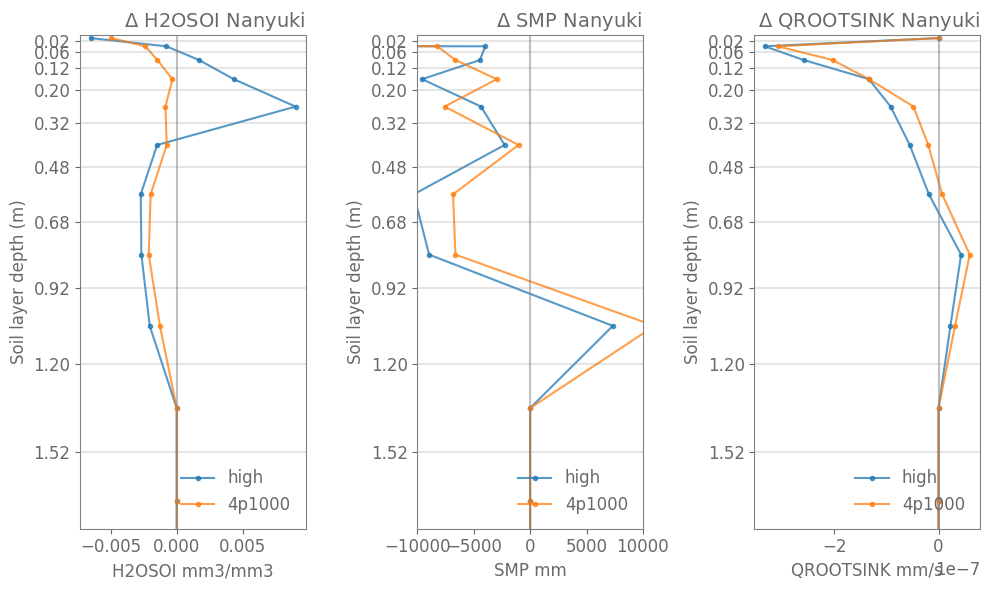

In [50]:
d_xlims = {'H2OSOI': False, 'SMP' : [-10000,10000], 'QROOTSINK' : False}
plot_delta_profiles(variables, d_xlims, d_delta_cell, marker, d_units)

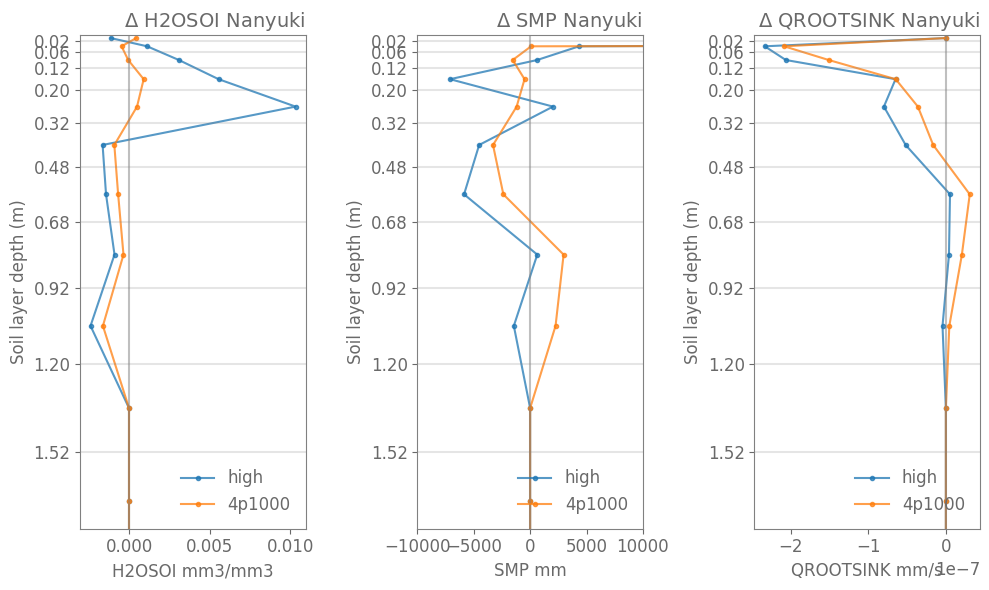

In [16]:
d_xlims = {'H2OSOI': False, 'SMP' : [-10000,10000], 'QROOTSINK' : False}
plot_delta_profiles(variables, d_xlims, d_delta_cell, marker, d_units)

### BERN

In [42]:
# select single grid cell to plot
lat_cell = 47.25
lon_cell = 7.25
marker   = 'Bern'
pft_int = pft_list_crops[0]
variables = ["H2OSOI", "SMP", "QROOTSINK"]



In [41]:
60/130

0.46153846153846156

In [ ]:
d_ctl_cell, d_scen_cell, d_delta_cell = calc_gridcell_means(variables, pft_int, lat_cell, lon_cell)

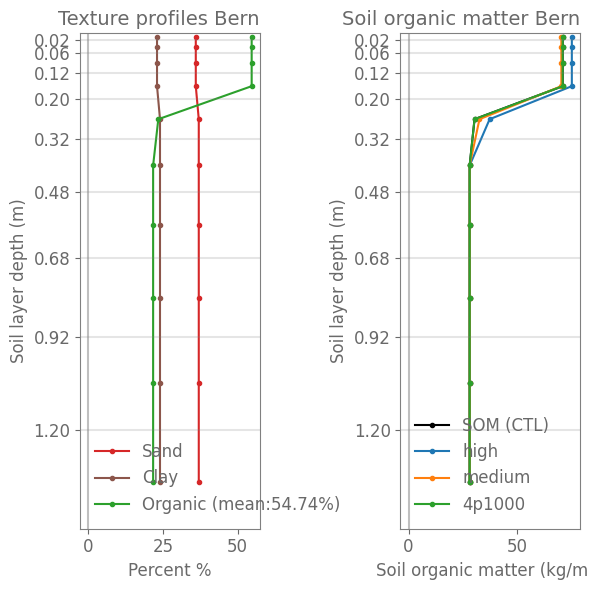

In [43]:
# plot difference profiles for water content, soil matric potential and root water uptake. 
pct_sand = ds_input['PCT_SAND'].sel(lat=lat_cell,lon=lon_cell)
pct_clay = ds_input['PCT_CLAY'].sel(lat=lat_cell,lon=lon_cell)
pct_organic = ds_input['ORGANIC'].sel(lat=lat_cell,lon=lon_cell)


fig, axes = plt.subplots(1,2,figsize=(6,6))

ax=axes[0]
ax.plot(pct_sand, levsoi[:len(pct_sand.nlevsoi.values)], marker='.', color='tab:red', label='Sand')
ax.plot(pct_clay, levsoi[:len(pct_sand.nlevsoi.values)], marker='.', color='tab:brown', label='Clay')
rel_pct_organic = (pct_organic / 130)*100
organic_label= 'Organic (mean:'+str(np.round(rel_pct_organic[0].values, 2))+'%)'
ax.plot(rel_pct_organic, levsoi[:len(pct_sand.nlevsoi.values)], marker='.', color='tab:green', label=organic_label)

ax.set_ylabel('Soil layer depth (m)'); 
ax.set_xlabel('Percent %')   
for depth in levsoi_depth:
    ax.axhline(depth,  color='grey', alpha=0.2)
ax.vlines(0, max(levgrnd_depth),0, color='grey', alpha=0.5)
#ax.set_xlim([50,100])
ax.set_yticks(levsoi_depth)
ax.set_ylim([1.5,0]); 
ax.legend(frameon=False)
ax.set_title('Texture profiles '+marker, loc='right' );

ax=axes[1]

ax.plot(pct_organic, levsoi[:len(pct_sand.nlevsoi.values)], marker='.',color = 'k',  label='SOM (CTL)')

# load for lat and lons
ds_lonlat = import_case(case_ctl, myVars=['TWS'], timeSlice=slice(str(start_year)+"-01-01", str(start_year)+"-02-01"), alter_lons=False)

for scenario in ['high','medium','4p1000']: 
    
    inputdir = procdir+'surfdata_4p1000/'
    ds_input = import_ds(inputdir+'surfdata_360x720cru_16pfts_Irrig_CMIP6_simyr2000_c170824_'+scenario+'.nc', myVars=input_variables,rename_lsmlatlon=True)

    # adapt lons and lats
    ds_input['lon'] = ds_lonlat['lon']
    ds_input['lat'] = ds_lonlat['lat']

    ds_input = lon_pm2idl(ds_input)
    
    pct_organic_scen = ds_input['ORGANIC'].sel(lat=lat_cell,lon=lon_cell)
    ax.plot(pct_organic_scen, levsoi[:len(pct_sand.nlevsoi.values)], marker='.', label=scenario)

ax.set_ylabel('Soil layer depth (m)'); 
ax.set_xlabel('Soil organic matter (kg/m3)')   
for depth in levsoi_depth:
    ax.axhline(depth,  color='grey', alpha=0.2)
ax.vlines(0, max(levgrnd_depth),0, color='grey', alpha=0.5)
#ax.set_xlim([50,100])
ax.set_yticks(levsoi_depth)
ax.set_ylim([1.5,0]); 
ax.legend(frameon=False)
ax.set_title('Soil organic matter '+marker, loc='right' );

fig.tight_layout()


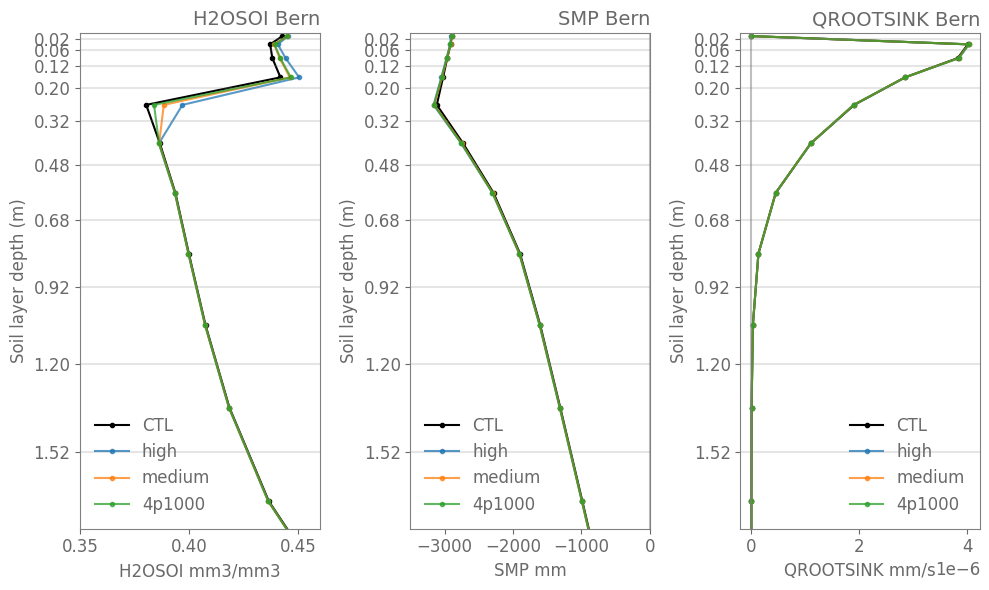

In [84]:
d_xlims = {'H2OSOI': [0.35,0.46], 'SMP' : [-3500,0], 'QROOTSINK' : False}
plot_abs_profiles(variables, d_xlims, d_ctl_cell, d_scen_cell, marker, d_units)

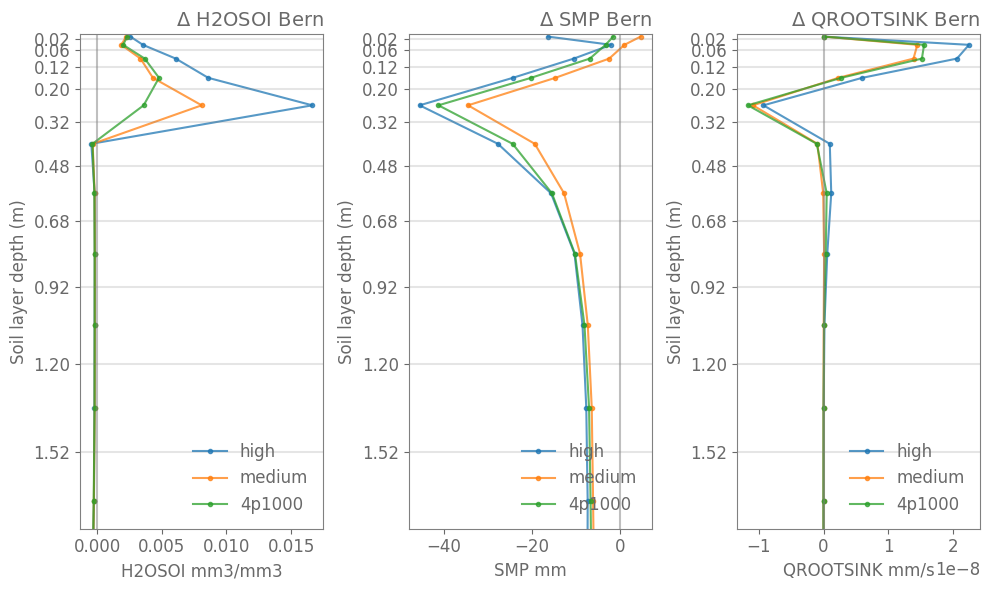

In [85]:
d_xlims = {'H2OSOI': False, 'SMP' : False, 'QROOTSINK' : False}
plot_delta_profiles(variables, d_xlims, d_delta_cell, marker, d_units)

### Arizona

In [46]:
# select single grid cell to plot
lat_cell = 35.25
lon_cell = -111.75
marker   = 'Arizona'
pft_int = pft_list_crops[0]



In [ ]:
d_ctl_cell, d_scen_cell, d_delta_cell = calc_gridcell_means(variables, pft_int, lat_cell, lon_cell)

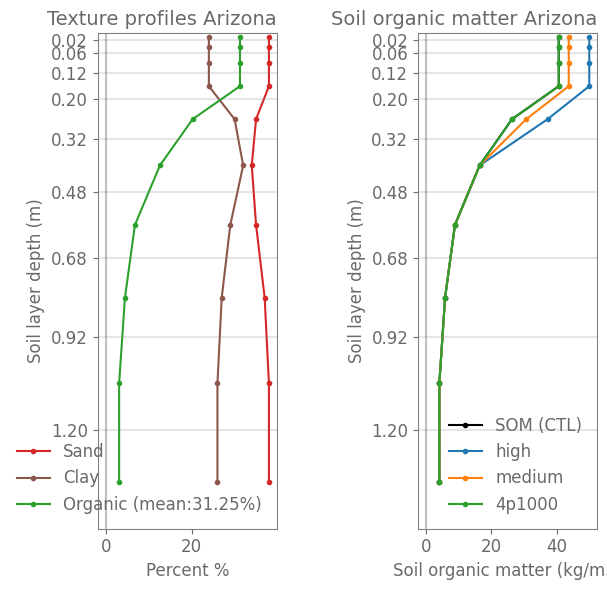

In [47]:
# plot difference profiles for water content, soil matric potential and root water uptake. 
pct_sand = ds_input['PCT_SAND'].sel(lat=lat_cell,lon=lon_cell)
pct_clay = ds_input['PCT_CLAY'].sel(lat=lat_cell,lon=lon_cell)
pct_organic = ds_input['ORGANIC'].sel(lat=lat_cell,lon=lon_cell)

fig, axes = plt.subplots(1,2,figsize=(6,6))

ax=axes[0]
ax.plot(pct_sand, levsoi[:len(pct_sand.nlevsoi.values)], marker='.', color='tab:red', label='Sand')
ax.plot(pct_clay, levsoi[:len(pct_sand.nlevsoi.values)], marker='.', color='tab:brown', label='Clay')

rel_pct_organic = (pct_organic / 130)*100
organic_label= 'Organic (mean:'+str(np.round(rel_pct_organic[0].values, 2))+'%)'
ax.plot(rel_pct_organic, levsoi[:len(pct_sand.nlevsoi.values)], marker='.', color='tab:green', label=organic_label)


ax.set_ylabel('Soil layer depth (m)'); 
ax.set_xlabel('Percent %')   
for depth in levsoi_depth:
    ax.axhline(depth,  color='grey', alpha=0.2)
ax.vlines(0, max(levgrnd_depth),0, color='grey', alpha=0.5)
#ax.set_xlim([50,100])
ax.set_yticks(levsoi_depth)
ax.set_ylim([1.5,0]); 
ax.legend(frameon=False)
ax.set_title('Texture profiles '+marker, loc='right' );

ax=axes[1]

ax.plot(pct_organic, levsoi[:len(pct_sand.nlevsoi.values)], marker='.',color = 'k',  label='SOM (CTL)')

# load for lat and lons
ds_lonlat = import_case(case_ctl, myVars=['TWS'], timeSlice=slice(str(start_year)+"-01-01", str(start_year)+"-02-01"), alter_lons=False)

for scenario in ['high','medium','4p1000']: 
    
    inputdir = procdir+'surfdata_4p1000/'
    ds_input = import_ds(inputdir+'surfdata_360x720cru_16pfts_Irrig_CMIP6_simyr2000_c170824_'+scenario+'.nc', myVars=input_variables,rename_lsmlatlon=True)

    # adapt lons and lats
    ds_input['lon'] = ds_lonlat['lon']
    ds_input['lat'] = ds_lonlat['lat']

    ds_input = lon_pm2idl(ds_input)
    
    pct_organic_scen = ds_input['ORGANIC'].sel(lat=lat_cell,lon=lon_cell)
    ax.plot(pct_organic_scen, levsoi[:len(pct_sand.nlevsoi.values)], marker='.', label=scenario)

ax.set_ylabel('Soil layer depth (m)'); 
ax.set_xlabel('Soil organic matter (kg/m3)')   
for depth in levsoi_depth:
    ax.axhline(depth,  color='grey', alpha=0.2)
ax.vlines(0, max(levgrnd_depth),0, color='grey', alpha=0.5)
#ax.set_xlim([50,100])
ax.set_yticks(levsoi_depth)
ax.set_ylim([1.5,0]); 
ax.legend(frameon=False)
ax.set_title('Soil organic matter '+marker, loc='right' );

fig.tight_layout()


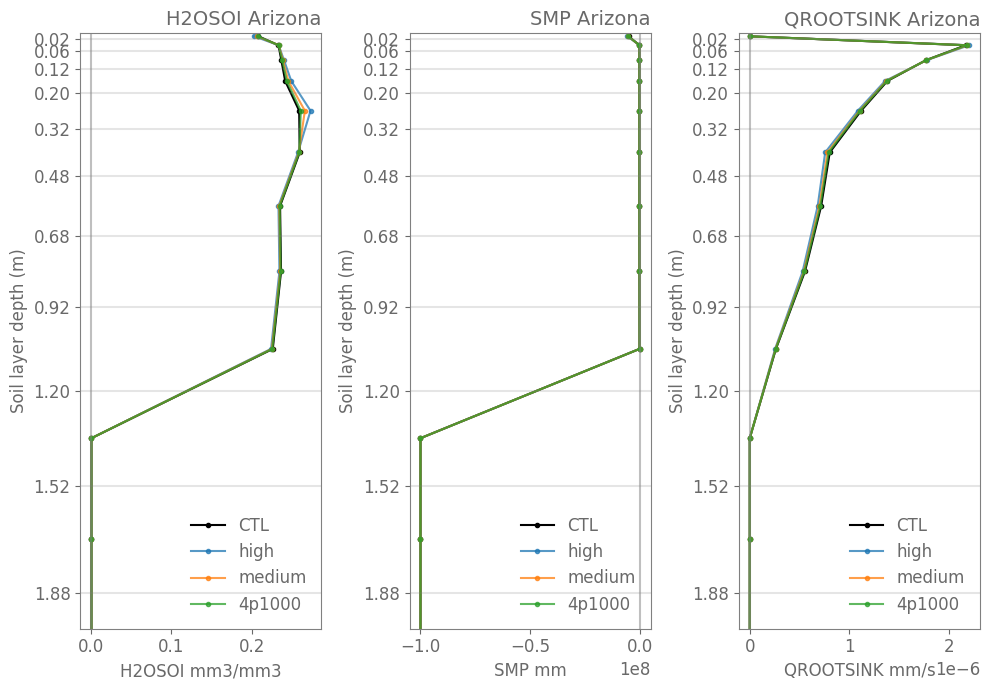

In [56]:
d_xlims = {'H2OSOI': False, 'SMP' : False,  'QROOTSINK' : False}
plot_abs_profiles(variables, d_xlims, d_ctl_cell, d_scen_cell, marker, d_units)

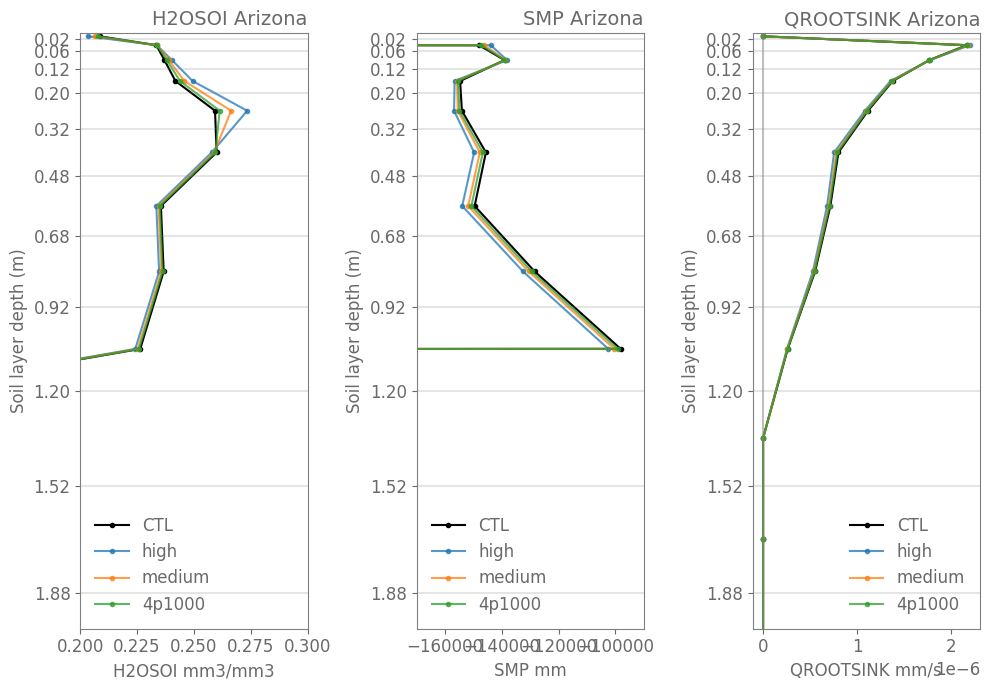

In [66]:
d_xlims = {'H2OSOI': [0.2,0.3], 'SMP' : [-17e4,-9e4],  'QROOTSINK' : False}
plot_abs_profiles(variables, d_xlims, d_ctl_cell, d_scen_cell, marker, d_units)

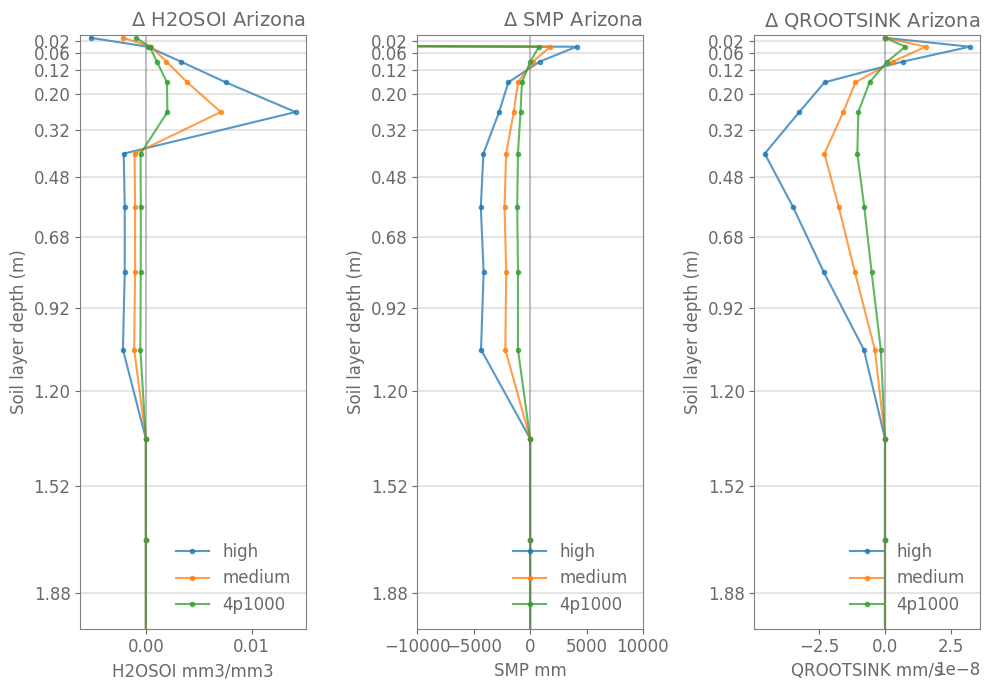

In [57]:
d_xlims = {'H2OSOI': False, 'SMP' : [-10000,10000], 'QROOTSINK' : False}
plot_delta_profiles(variables, d_xlims, d_delta_cell, marker, d_units)

### Rajasthan

In [48]:
# select single grid cell to plot
lat_cell = 27.25
lon_cell = 72.75
marker   = 'Rajasthan'
pft_int = pft_list_crops[0]



In [119]:
d_ctl_cell, d_scen_cell, d_delta_cell = calc_gridcell_means(variables, pft_int, lat_cell, lon_cell)

loading grid cell values of H2OSOI
loading grid cell values of SMP
loading grid cell values of QROOTSINK


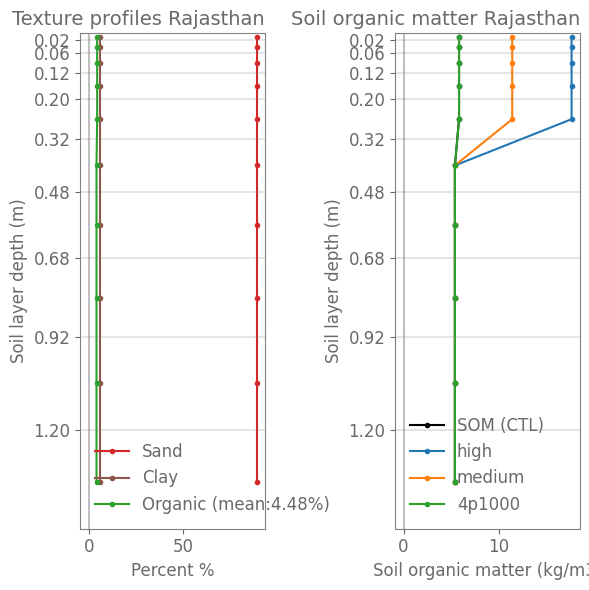

In [49]:
# plot difference profiles for water content, soil matric potential and root water uptake. 
pct_sand = ds_input['PCT_SAND'].sel(lat=lat_cell,lon=lon_cell)
pct_clay = ds_input['PCT_CLAY'].sel(lat=lat_cell,lon=lon_cell)
pct_organic = ds_input['ORGANIC'].sel(lat=lat_cell,lon=lon_cell)


fig, axes = plt.subplots(1,2,figsize=(6,6))

ax=axes[0]
ax.plot(pct_sand, levsoi[:len(pct_sand.nlevsoi.values)], marker='.', color='tab:red', label='Sand')
ax.plot(pct_clay, levsoi[:len(pct_sand.nlevsoi.values)], marker='.', color='tab:brown', label='Clay')
rel_pct_organic = (pct_organic / 130)*100
organic_label= 'Organic (mean:'+str(np.round(rel_pct_organic[0].values, 2))+'%)'
ax.plot(rel_pct_organic, levsoi[:len(pct_sand.nlevsoi.values)], marker='.', color='tab:green', label=organic_label)

ax.set_ylabel('Soil layer depth (m)'); 
ax.set_xlabel('Percent %')   
for depth in levsoi_depth:
    ax.axhline(depth,  color='grey', alpha=0.2)
ax.vlines(0, max(levgrnd_depth),0, color='grey', alpha=0.5)
#ax.set_xlim([50,100])
ax.set_yticks(levsoi_depth)
ax.set_ylim([1.5,0]); 
ax.legend(frameon=False)
ax.set_title('Texture profiles '+marker, loc='right' );

ax=axes[1]

ax.plot(pct_organic, levsoi[:len(pct_sand.nlevsoi.values)], marker='.',color = 'k',  label='SOM (CTL)')

# load for lat and lons
ds_lonlat = import_case(case_ctl, myVars=['TWS'], timeSlice=slice(str(start_year)+"-01-01", str(start_year)+"-02-01"), alter_lons=False)

for scenario in ['high','medium','4p1000']: 
    
    inputdir = procdir+'surfdata_4p1000/'
    ds_input = import_ds(inputdir+'surfdata_360x720cru_16pfts_Irrig_CMIP6_simyr2000_c170824_'+scenario+'.nc', myVars=input_variables,rename_lsmlatlon=True)

    # adapt lons and lats
    ds_input['lon'] = ds_lonlat['lon']
    ds_input['lat'] = ds_lonlat['lat']

    ds_input = lon_pm2idl(ds_input)
    
    pct_organic_scen = ds_input['ORGANIC'].sel(lat=lat_cell,lon=lon_cell)
    ax.plot(pct_organic_scen, levsoi[:len(pct_sand.nlevsoi.values)], marker='.', label=scenario)

ax.set_ylabel('Soil layer depth (m)'); 
ax.set_xlabel('Soil organic matter (kg/m3)')   
for depth in levsoi_depth:
    ax.axhline(depth,  color='grey', alpha=0.2)
ax.vlines(0, max(levgrnd_depth),0, color='grey', alpha=0.5)
#ax.set_xlim([50,100])
ax.set_yticks(levsoi_depth)
ax.set_ylim([1.5,0]); 
ax.legend(frameon=False)
ax.set_title('Soil organic matter '+marker, loc='right' );

fig.tight_layout()


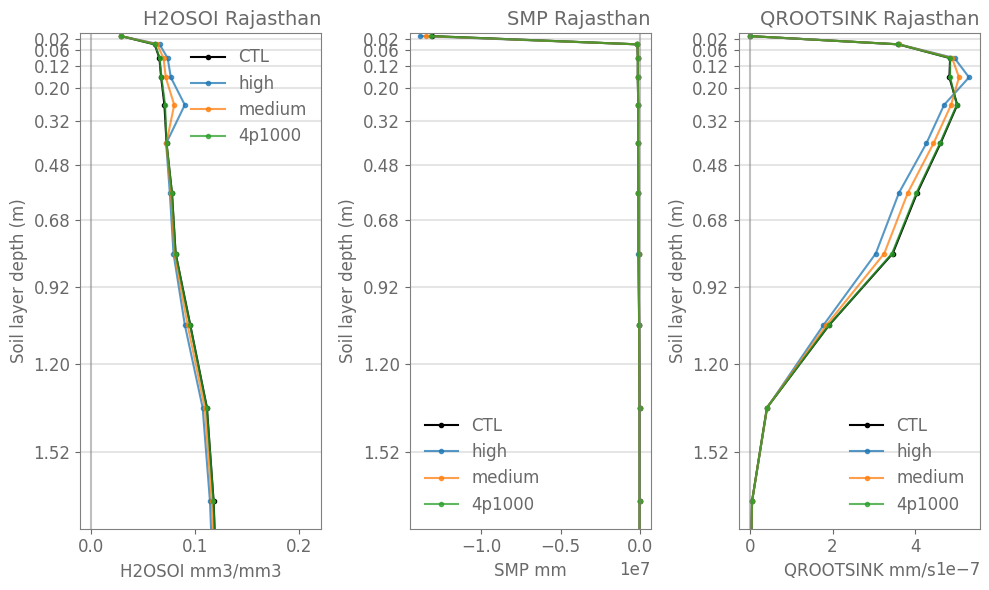

In [89]:
d_xlims = {'H2OSOI': False, 'SMP' : [-15e5,0],  'QROOTSINK' : False}
plot_abs_profiles(variables, d_xlims, d_ctl_cell, d_scen_cell, marker, d_units)

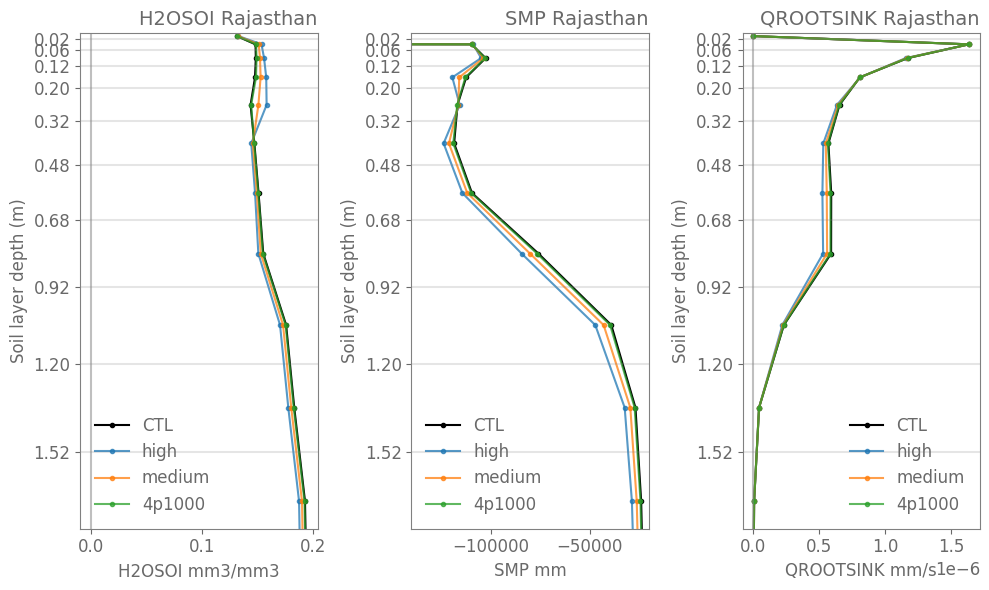

In [123]:
d_xlims = {'H2OSOI': False, 'SMP' : [-14e4,-2e4],  'QROOTSINK' : False}
plot_abs_profiles(variables, d_xlims, d_ctl_cell, d_scen_cell, marker, d_units)

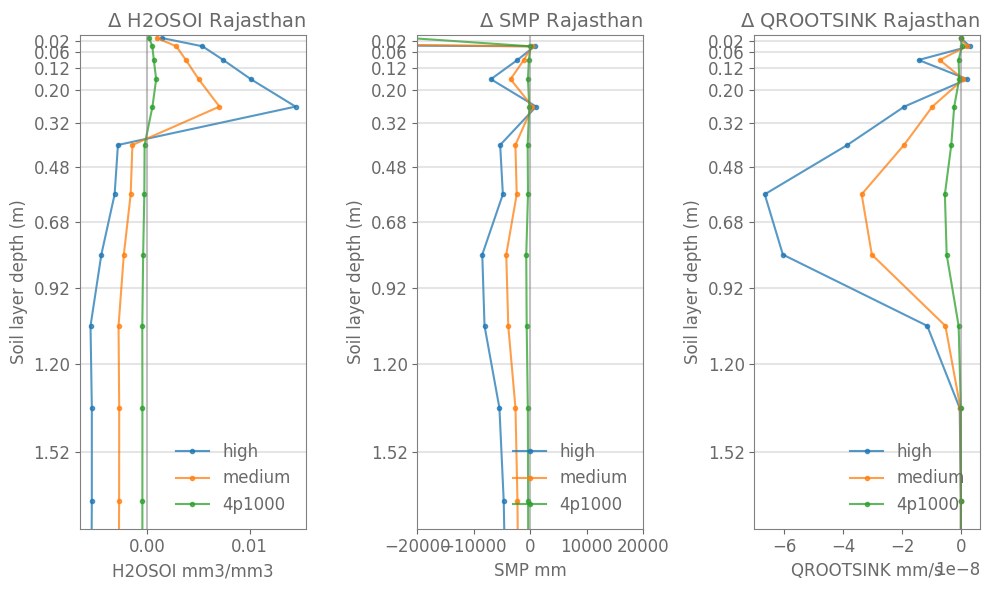

In [124]:
d_xlims = {'H2OSOI': False, 'SMP' : [-20000,20000], 'QROOTSINK' : False}
plot_delta_profiles(variables, d_xlims, d_delta_cell, marker, d_units)

### Almeria

In [50]:
# select single grid cell to plot
lat_cell = 37.25
lon_cell = -2.25
marker   = 'Andalusia'
pft_int = pft_list_crops[0]



In [126]:
d_ctl_cell, d_scen_cell, d_delta_cell = calc_gridcell_means(variables, pft_int, lat_cell, lon_cell)

loading grid cell values of H2OSOI
loading grid cell values of SMP
loading grid cell values of QROOTSINK


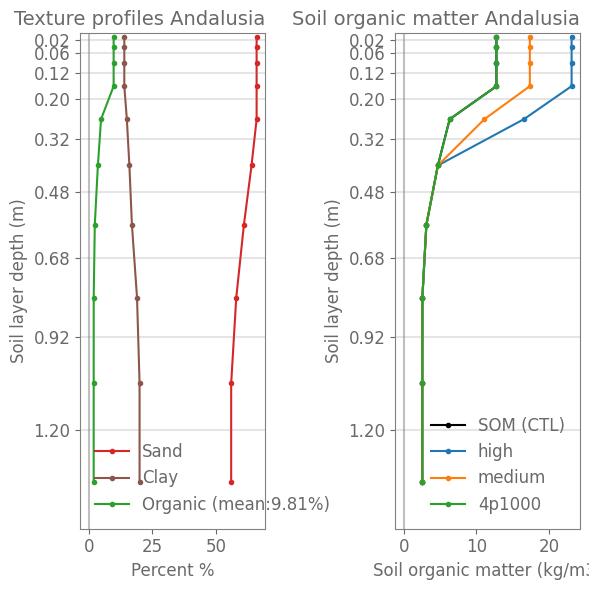

In [51]:
# plot difference profiles for water content, soil matric potential and root water uptake. 
pct_sand = ds_input['PCT_SAND'].sel(lat=lat_cell,lon=lon_cell)
pct_clay = ds_input['PCT_CLAY'].sel(lat=lat_cell,lon=lon_cell)
pct_organic = ds_input['ORGANIC'].sel(lat=lat_cell,lon=lon_cell)


fig, axes = plt.subplots(1,2,figsize=(6,6))

ax=axes[0]
ax.plot(pct_sand, levsoi[:len(pct_sand.nlevsoi.values)], marker='.', color='tab:red', label='Sand')
ax.plot(pct_clay, levsoi[:len(pct_sand.nlevsoi.values)], marker='.', color='tab:brown', label='Clay')
rel_pct_organic = (pct_organic / 130)*100
organic_label= 'Organic (mean:'+str(np.round(rel_pct_organic[0].values, 2))+'%)'
ax.plot(rel_pct_organic, levsoi[:len(pct_sand.nlevsoi.values)], marker='.', color='tab:green', label=organic_label)

ax.set_ylabel('Soil layer depth (m)'); 
ax.set_xlabel('Percent %')   
for depth in levsoi_depth:
    ax.axhline(depth,  color='grey', alpha=0.2)
ax.vlines(0, max(levgrnd_depth),0, color='grey', alpha=0.5)
#ax.set_xlim([50,100])
ax.set_yticks(levsoi_depth)
ax.set_ylim([1.5,0]); 
ax.legend(frameon=False)
ax.set_title('Texture profiles '+marker, loc='right' );

ax=axes[1]

ax.plot(pct_organic, levsoi[:len(pct_sand.nlevsoi.values)], marker='.',color = 'k',  label='SOM (CTL)')

# load for lat and lons
ds_lonlat = import_case(case_ctl, myVars=['TWS'], timeSlice=slice(str(start_year)+"-01-01", str(start_year)+"-02-01"), alter_lons=False)

for scenario in ['high','medium','4p1000']: 
    
    inputdir = procdir+'surfdata_4p1000/'
    ds_input = import_ds(inputdir+'surfdata_360x720cru_16pfts_Irrig_CMIP6_simyr2000_c170824_'+scenario+'.nc', myVars=input_variables,rename_lsmlatlon=True)

    # adapt lons and lats
    ds_input['lon'] = ds_lonlat['lon']
    ds_input['lat'] = ds_lonlat['lat']

    ds_input = lon_pm2idl(ds_input)
    
    pct_organic_scen = ds_input['ORGANIC'].sel(lat=lat_cell,lon=lon_cell)
    ax.plot(pct_organic_scen, levsoi[:len(pct_sand.nlevsoi.values)], marker='.', label=scenario)

ax.set_ylabel('Soil layer depth (m)'); 
ax.set_xlabel('Soil organic matter (kg/m3)')   
for depth in levsoi_depth:
    ax.axhline(depth,  color='grey', alpha=0.2)
ax.vlines(0, max(levgrnd_depth),0, color='grey', alpha=0.5)
#ax.set_xlim([50,100])
ax.set_yticks(levsoi_depth)
ax.set_ylim([1.5,0]); 
ax.legend(frameon=False)
ax.set_title('Soil organic matter '+marker, loc='right' );

fig.tight_layout()


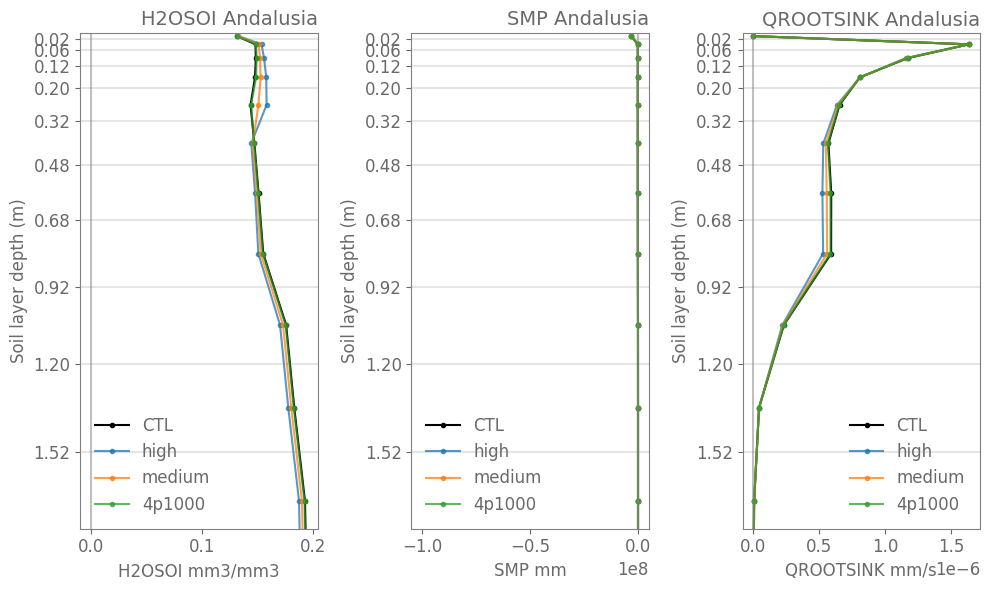

In [129]:
d_xlims = {'H2OSOI': False, 'SMP' : False,  'QROOTSINK' : False}
plot_abs_profiles(variables, d_xlims, d_ctl_cell, d_scen_cell, marker, d_units)

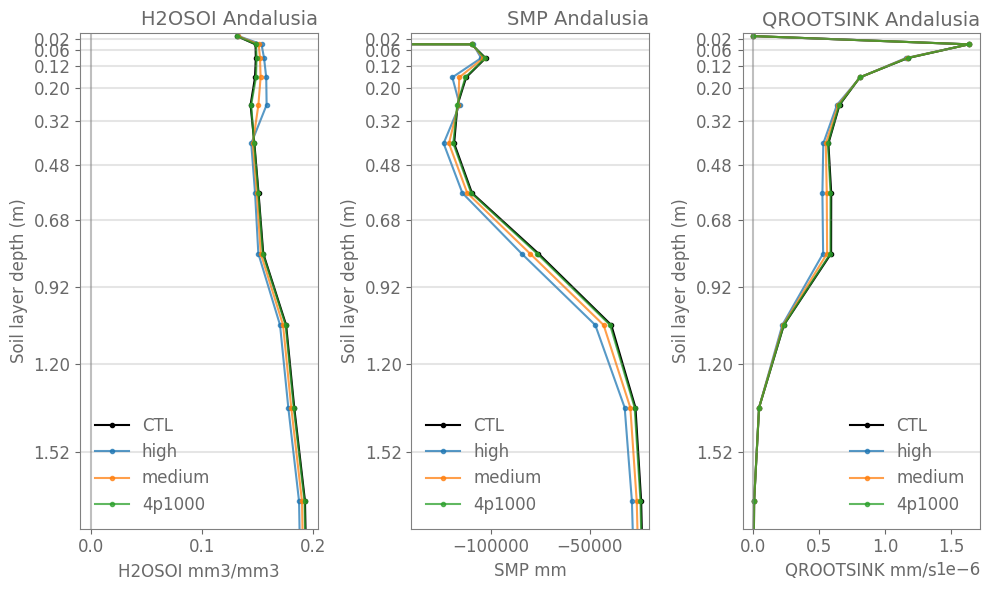

In [127]:
d_xlims = {'H2OSOI': False, 'SMP' : [-14e4,-2e4],  'QROOTSINK' : False}
plot_abs_profiles(variables, d_xlims, d_ctl_cell, d_scen_cell, marker, d_units)

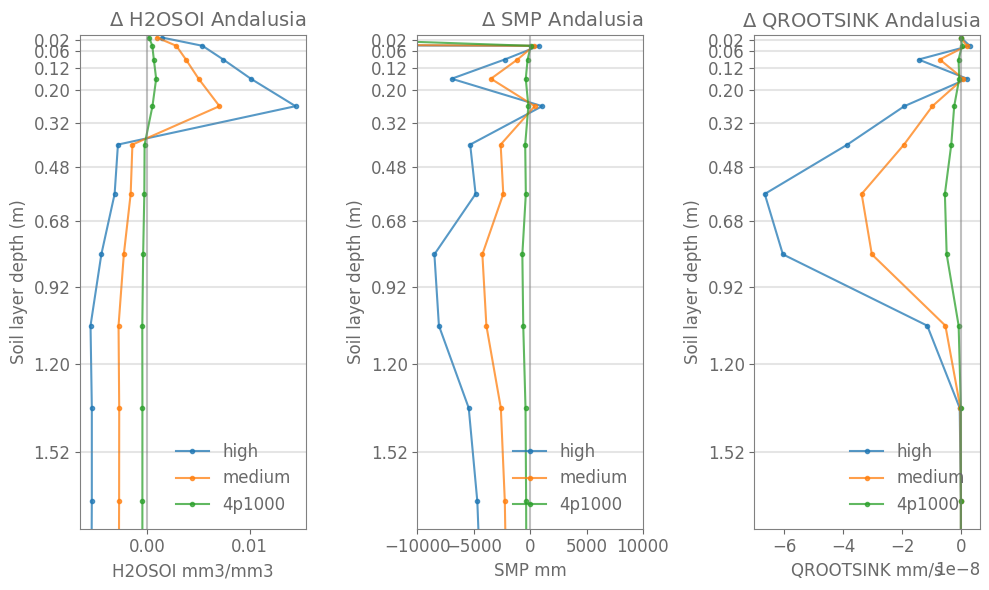

In [128]:
d_xlims = {'H2OSOI': False, 'SMP' : [-10000,10000], 'QROOTSINK' : False}
plot_delta_profiles(variables, d_xlims, d_delta_cell, marker, d_units)

### Namibia

In [52]:
# select single grid cell to plot
lat_cell = -22.25
lon_cell = 17.25
marker   = 'Namibia'
pft_int = pft_list_crops[0]



In [99]:
d_ctl_cell, d_scen_cell, d_delta_cell = calc_gridcell_means(variables, pft_int, lat_cell, lon_cell)

loading grid cell values of H2OSOI
loading grid cell values of SMP
loading grid cell values of QROOTSINK


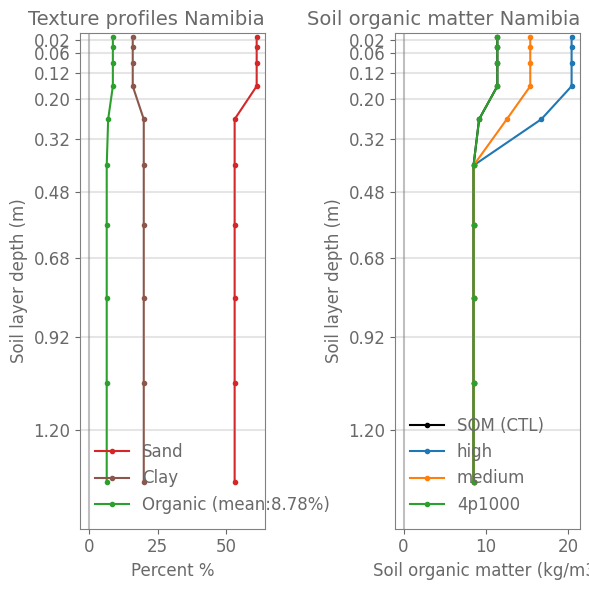

In [53]:
# plot difference profiles for water content, soil matric potential and root water uptake. 
pct_sand = ds_input['PCT_SAND'].sel(lat=lat_cell,lon=lon_cell)
pct_clay = ds_input['PCT_CLAY'].sel(lat=lat_cell,lon=lon_cell)
pct_organic = ds_input['ORGANIC'].sel(lat=lat_cell,lon=lon_cell)


fig, axes = plt.subplots(1,2,figsize=(6,6))

ax=axes[0]
ax.plot(pct_sand, levsoi[:len(pct_sand.nlevsoi.values)], marker='.', color='tab:red', label='Sand')
ax.plot(pct_clay, levsoi[:len(pct_sand.nlevsoi.values)], marker='.', color='tab:brown', label='Clay')
rel_pct_organic = (pct_organic / 130)*100
organic_label= 'Organic (mean:'+str(np.round(rel_pct_organic[0].values, 2))+'%)'
ax.plot(rel_pct_organic, levsoi[:len(pct_sand.nlevsoi.values)], marker='.', color='tab:green', label=organic_label)

ax.set_ylabel('Soil layer depth (m)'); 
ax.set_xlabel('Percent %')   
for depth in levsoi_depth:
    ax.axhline(depth,  color='grey', alpha=0.2)
ax.vlines(0, max(levgrnd_depth),0, color='grey', alpha=0.5)
#ax.set_xlim([50,100])
ax.set_yticks(levsoi_depth)
ax.set_ylim([1.5,0]); 
ax.legend(frameon=False)
ax.set_title('Texture profiles '+marker, loc='right' );

ax=axes[1]

ax.plot(pct_organic, levsoi[:len(pct_sand.nlevsoi.values)], marker='.',color = 'k',  label='SOM (CTL)')

# load for lat and lons
ds_lonlat = import_case(case_ctl, myVars=['TWS'], timeSlice=slice(str(start_year)+"-01-01", str(start_year)+"-02-01"), alter_lons=False)

for scenario in ['high','medium','4p1000']: 
    
    inputdir = procdir+'surfdata_4p1000/'
    ds_input = import_ds(inputdir+'surfdata_360x720cru_16pfts_Irrig_CMIP6_simyr2000_c170824_'+scenario+'.nc', myVars=input_variables,rename_lsmlatlon=True)

    # adapt lons and lats
    ds_input['lon'] = ds_lonlat['lon']
    ds_input['lat'] = ds_lonlat['lat']

    ds_input = lon_pm2idl(ds_input)
    
    pct_organic_scen = ds_input['ORGANIC'].sel(lat=lat_cell,lon=lon_cell)
    ax.plot(pct_organic_scen, levsoi[:len(pct_sand.nlevsoi.values)], marker='.', label=scenario)

ax.set_ylabel('Soil layer depth (m)'); 
ax.set_xlabel('Soil organic matter (kg/m3)')   
for depth in levsoi_depth:
    ax.axhline(depth,  color='grey', alpha=0.2)
ax.vlines(0, max(levgrnd_depth),0, color='grey', alpha=0.5)
#ax.set_xlim([50,100])
ax.set_yticks(levsoi_depth)
ax.set_ylim([1.5,0]); 
ax.legend(frameon=False)
ax.set_title('Soil organic matter '+marker, loc='right' );

fig.tight_layout()


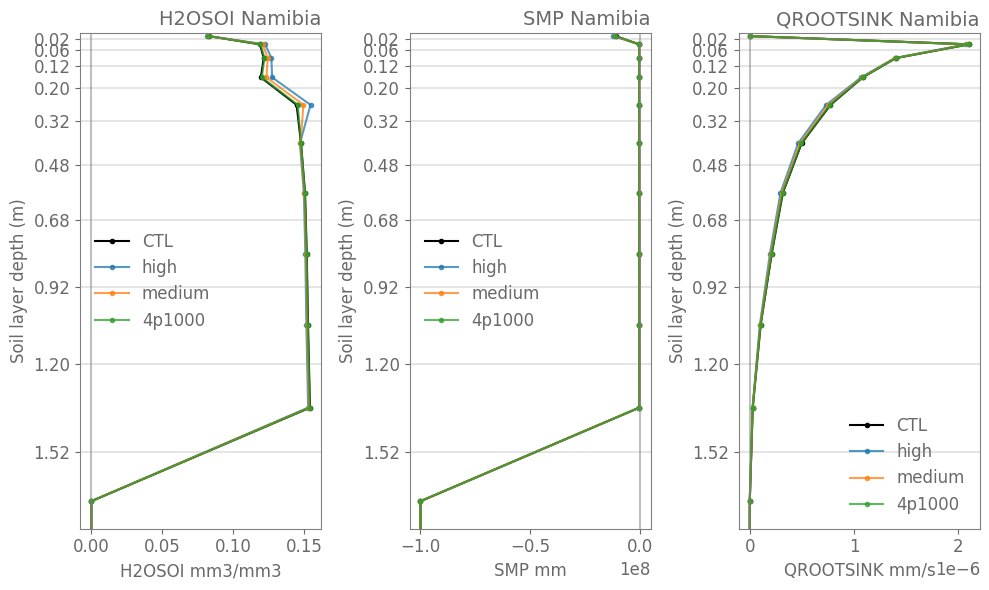

In [101]:
d_xlims = {'H2OSOI': False, 'SMP' : False,  'QROOTSINK' : False}
plot_abs_profiles(variables, d_xlims, d_ctl_cell, d_scen_cell, marker, d_units)

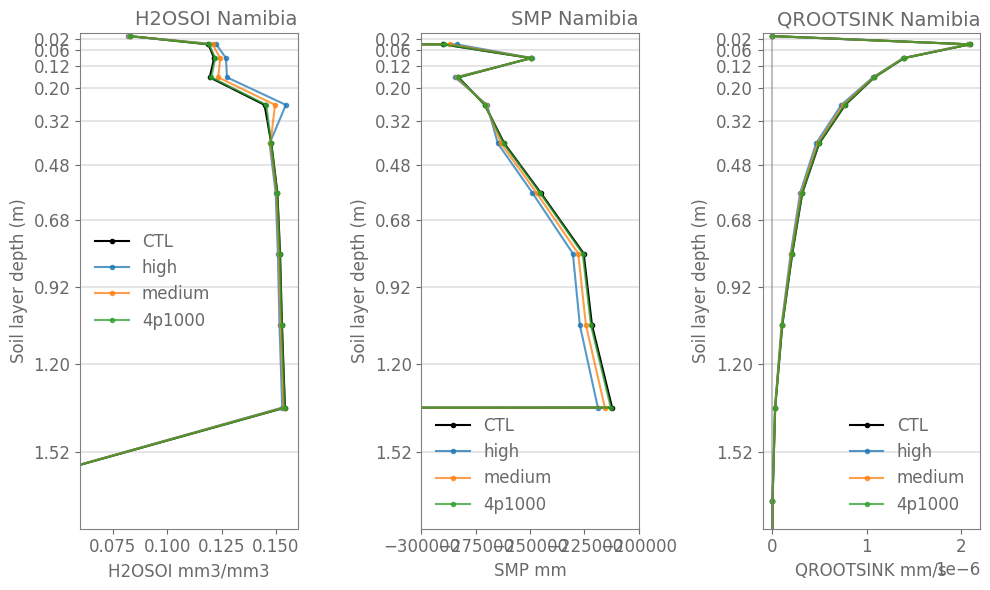

In [108]:
d_xlims = {'H2OSOI': [0.06,0.16], 'SMP' : [-3e5,-2e5],  'QROOTSINK' : False}
plot_abs_profiles(variables, d_xlims, d_ctl_cell, d_scen_cell, marker, d_units)

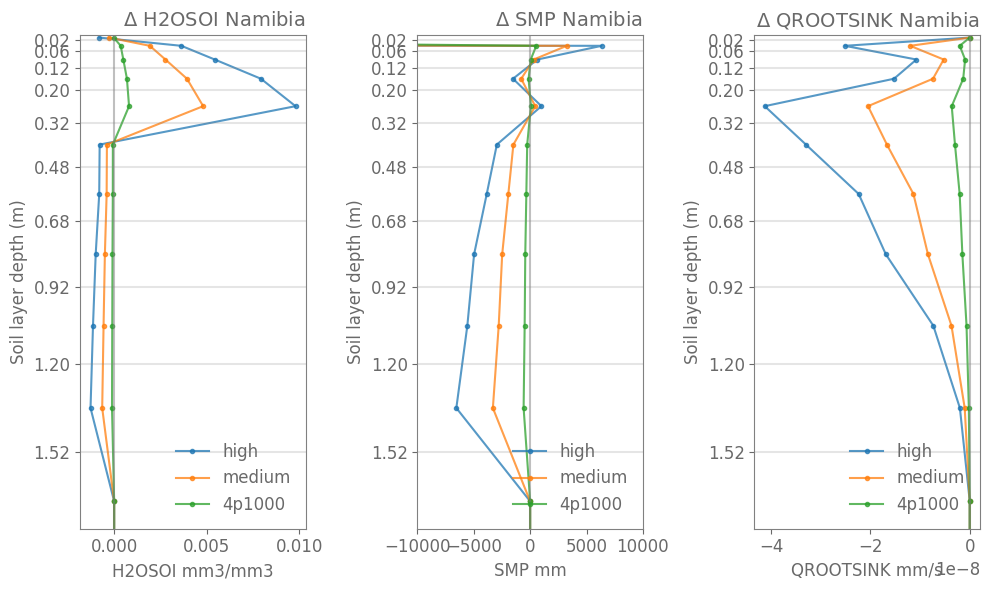

In [103]:
d_xlims = {'H2OSOI': False, 'SMP' : [-10000,10000], 'QROOTSINK' : False}
plot_delta_profiles(variables, d_xlims, d_delta_cell, marker, d_units)

### Indore (high clay)

In [54]:
# select single grid cell to plot
lat_cell = 22.75
lon_cell = 76.25
marker   = 'Indore'
pft_int = pft_list_crops[0]

In [26]:
d_ctl_cell, d_scen_cell, d_delta_cell = calc_gridcell_means(variables, pft_int, lat_cell, lon_cell)

loading grid cell values of H2OSOI
loading grid cell values of SMP
loading grid cell values of QROOTSINK


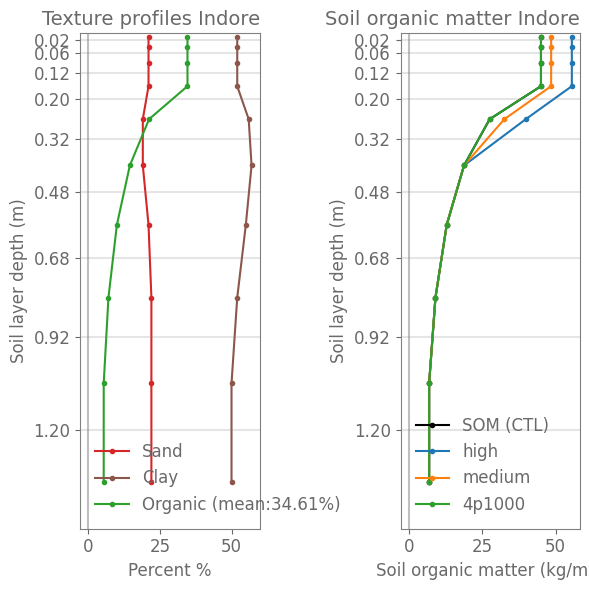

In [55]:
# plot difference profiles for water content, soil matric potential and root water uptake. 
pct_sand = ds_input['PCT_SAND'].sel(lat=lat_cell,lon=lon_cell)
pct_clay = ds_input['PCT_CLAY'].sel(lat=lat_cell,lon=lon_cell)
pct_organic = ds_input['ORGANIC'].sel(lat=lat_cell,lon=lon_cell)


fig, axes = plt.subplots(1,2,figsize=(6,6))

ax=axes[0]
ax.plot(pct_sand, levsoi[:len(pct_sand.nlevsoi.values)], marker='.', color='tab:red', label='Sand')
ax.plot(pct_clay, levsoi[:len(pct_sand.nlevsoi.values)], marker='.', color='tab:brown', label='Clay')
rel_pct_organic = (pct_organic / 130)*100
organic_label= 'Organic (mean:'+str(np.round(rel_pct_organic[0].values, 2))+'%)'
ax.plot(rel_pct_organic, levsoi[:len(pct_sand.nlevsoi.values)], marker='.', color='tab:green', label=organic_label)

ax.set_ylabel('Soil layer depth (m)'); 
ax.set_xlabel('Percent %')   
for depth in levsoi_depth:
    ax.axhline(depth,  color='grey', alpha=0.2)
ax.vlines(0, max(levgrnd_depth),0, color='grey', alpha=0.5)
#ax.set_xlim([50,100])
ax.set_yticks(levsoi_depth)
ax.set_ylim([1.5,0]); 
ax.legend(frameon=False)
ax.set_title('Texture profiles '+marker, loc='right' );

ax=axes[1]

ax.plot(pct_organic, levsoi[:len(pct_sand.nlevsoi.values)], marker='.',color = 'k',  label='SOM (CTL)')

# load for lat and lons
ds_lonlat = import_case(case_ctl, myVars=['TWS'], timeSlice=slice(str(start_year)+"-01-01", str(start_year)+"-02-01"), alter_lons=False)

for scenario in ['high','medium','4p1000']: 
    
    inputdir = procdir+'surfdata_4p1000/'
    ds_input = import_ds(inputdir+'surfdata_360x720cru_16pfts_Irrig_CMIP6_simyr2000_c170824_'+scenario+'.nc', myVars=input_variables,rename_lsmlatlon=True)

    # adapt lons and lats
    ds_input['lon'] = ds_lonlat['lon']
    ds_input['lat'] = ds_lonlat['lat']

    ds_input = lon_pm2idl(ds_input)
    
    pct_organic_scen = ds_input['ORGANIC'].sel(lat=lat_cell,lon=lon_cell)
    ax.plot(pct_organic_scen, levsoi[:len(pct_sand.nlevsoi.values)], marker='.', label=scenario)

ax.set_ylabel('Soil layer depth (m)'); 
ax.set_xlabel('Soil organic matter (kg/m3)')   
for depth in levsoi_depth:
    ax.axhline(depth,  color='grey', alpha=0.2)
ax.vlines(0, max(levgrnd_depth),0, color='grey', alpha=0.5)
#ax.set_xlim([50,100])
ax.set_yticks(levsoi_depth)
ax.set_ylim([1.5,0]); 
ax.legend(frameon=False)
ax.set_title('Soil organic matter '+marker, loc='right' );

fig.tight_layout()


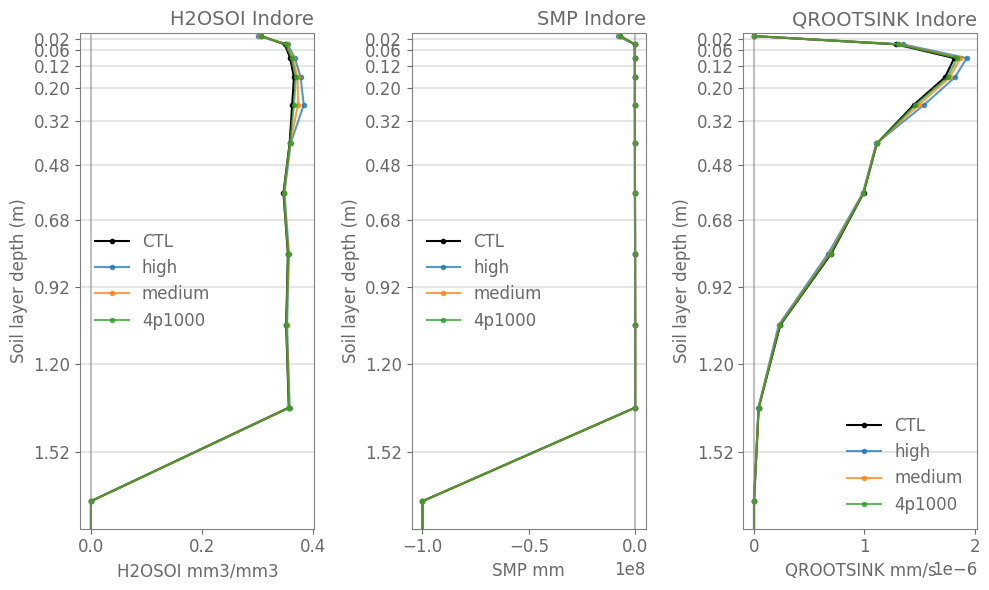

In [137]:
d_xlims = {'H2OSOI': False, 'SMP' : False,  'QROOTSINK' : False}
plot_abs_profiles(variables, d_xlims, d_ctl_cell, d_scen_cell, marker, d_units)

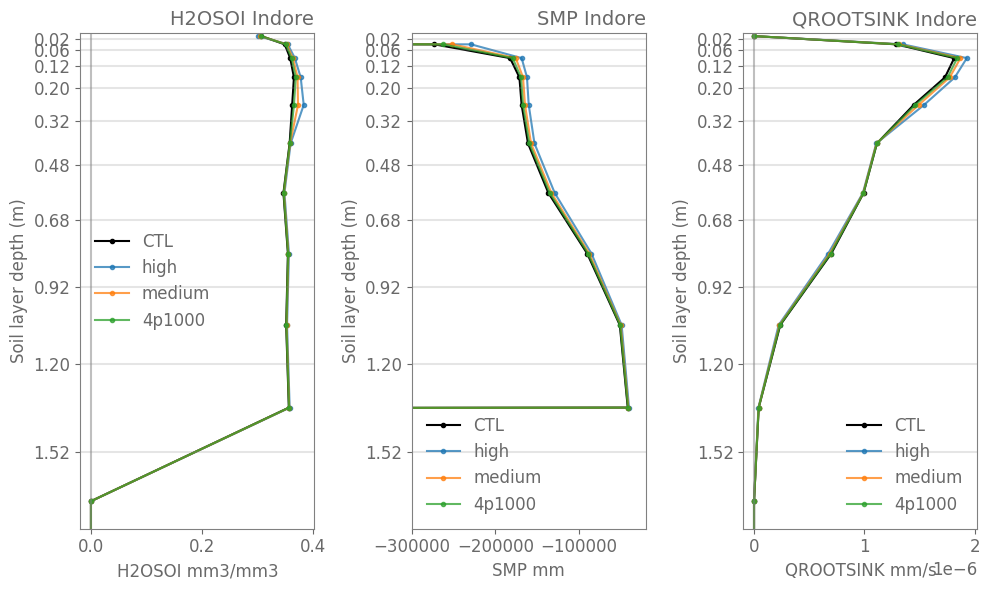

In [141]:
d_xlims = {'H2OSOI': False, 'SMP' : [-30e4,-2e4],  'QROOTSINK' : False}
plot_abs_profiles(variables, d_xlims, d_ctl_cell, d_scen_cell, marker, d_units)

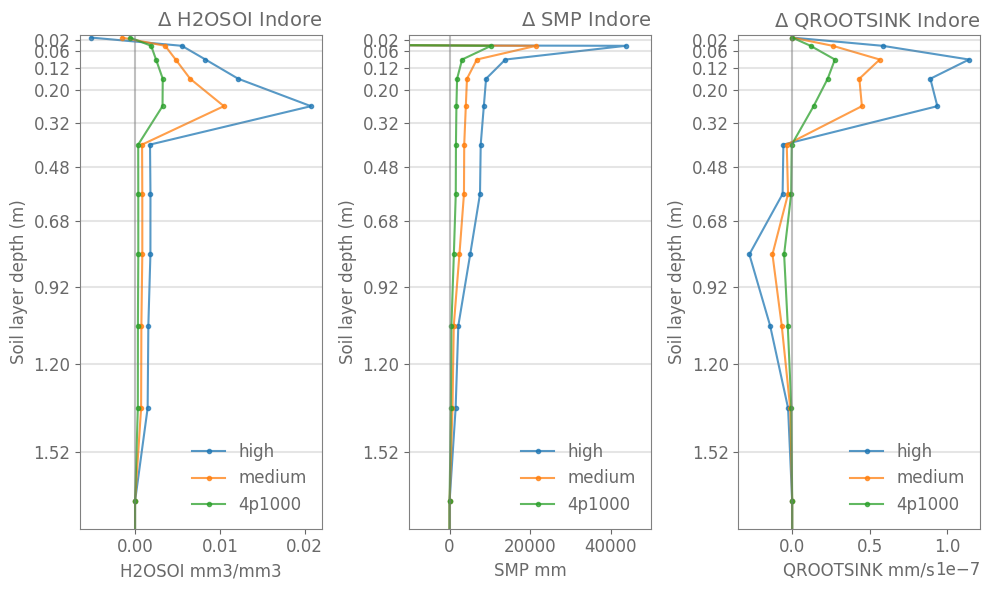

In [29]:
d_xlims = {'H2OSOI': False, 'SMP' : [-1e4,5e4], 'QROOTSINK' : False}
plot_delta_profiles(variables, d_xlims, d_delta_cell, marker, d_units)

### Springfield (high sand, wet)

In [56]:
# select single grid cell to plot
lat_cell = 42.75
lon_cell = -72.75
marker   = 'Springfield'
pft_int = pft_list_crops[0]


In [13]:
d_ctl_cell, d_scen_cell, d_delta_cell = calc_gridcell_means(variables, pft_int, lat_cell, lon_cell)

loading grid cell values of H2OSOI
loading grid cell values of SMP
loading grid cell values of QROOTSINK


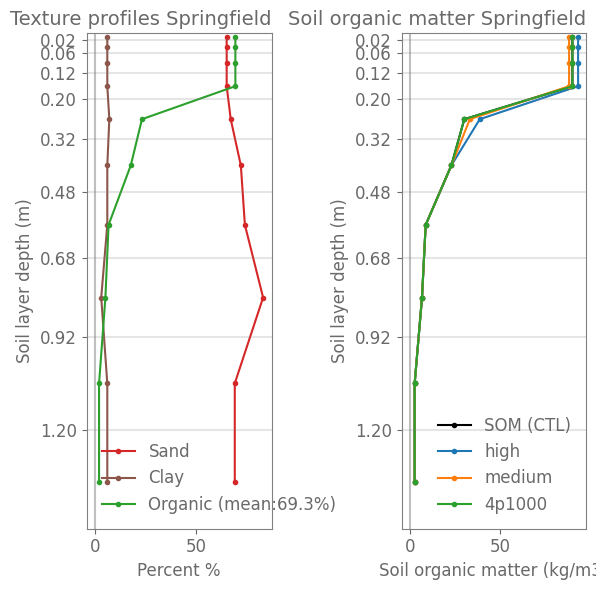

In [57]:
# plot difference profiles for water content, soil matric potential and root water uptake. 
pct_sand = ds_input['PCT_SAND'].sel(lat=lat_cell,lon=lon_cell)
pct_clay = ds_input['PCT_CLAY'].sel(lat=lat_cell,lon=lon_cell)
pct_organic = ds_input['ORGANIC'].sel(lat=lat_cell,lon=lon_cell)


fig, axes = plt.subplots(1,2,figsize=(6,6))

ax=axes[0]
ax.plot(pct_sand, levsoi[:len(pct_sand.nlevsoi.values)], marker='.', color='tab:red', label='Sand')
ax.plot(pct_clay, levsoi[:len(pct_sand.nlevsoi.values)], marker='.', color='tab:brown', label='Clay')
rel_pct_organic = (pct_organic / 130)*100
organic_label= 'Organic (mean:'+str(np.round(rel_pct_organic[0].values, 2))+'%)'
ax.plot(rel_pct_organic, levsoi[:len(pct_sand.nlevsoi.values)], marker='.', color='tab:green', label=organic_label)

ax.set_ylabel('Soil layer depth (m)'); 
ax.set_xlabel('Percent %')   
for depth in levsoi_depth:
    ax.axhline(depth,  color='grey', alpha=0.2)
ax.vlines(0, max(levgrnd_depth),0, color='grey', alpha=0.5)
#ax.set_xlim([50,100])
ax.set_yticks(levsoi_depth)
ax.set_ylim([1.5,0]); 
ax.legend(frameon=False)
ax.set_title('Texture profiles '+marker, loc='right' );

ax=axes[1]

ax.plot(pct_organic, levsoi[:len(pct_sand.nlevsoi.values)], marker='.',color = 'k',  label='SOM (CTL)')

# load for lat and lons
ds_lonlat = import_case(case_ctl, myVars=['TWS'], timeSlice=slice(str(start_year)+"-01-01", str(start_year)+"-02-01"), alter_lons=False)

for scenario in ['high','medium','4p1000']: 
    
    inputdir = procdir+'surfdata_4p1000/'
    ds_input = import_ds(inputdir+'surfdata_360x720cru_16pfts_Irrig_CMIP6_simyr2000_c170824_'+scenario+'.nc', myVars=input_variables,rename_lsmlatlon=True)

    # adapt lons and lats
    ds_input['lon'] = ds_lonlat['lon']
    ds_input['lat'] = ds_lonlat['lat']

    ds_input = lon_pm2idl(ds_input)
    
    pct_organic_scen = ds_input['ORGANIC'].sel(lat=lat_cell,lon=lon_cell)
    ax.plot(pct_organic_scen, levsoi[:len(pct_sand.nlevsoi.values)], marker='.', label=scenario)

ax.set_ylabel('Soil layer depth (m)'); 
ax.set_xlabel('Soil organic matter (kg/m3)')   
for depth in levsoi_depth:
    ax.axhline(depth,  color='grey', alpha=0.2)
ax.vlines(0, max(levgrnd_depth),0, color='grey', alpha=0.5)
#ax.set_xlim([50,100])
ax.set_yticks(levsoi_depth)
ax.set_ylim([1.5,0]); 
ax.legend(frameon=False)
ax.set_title('Soil organic matter '+marker, loc='right' );

fig.tight_layout()


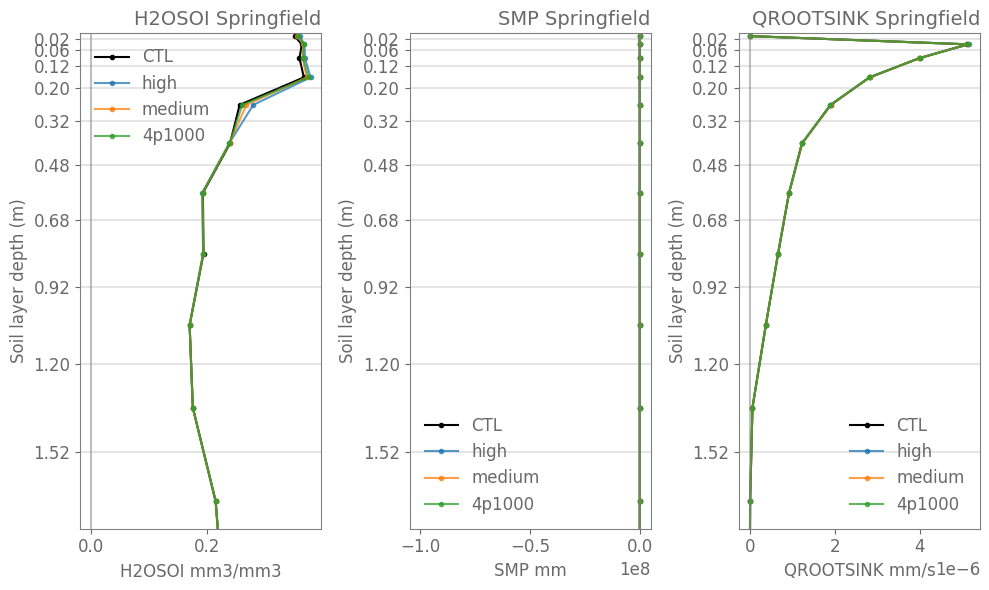

In [15]:
d_xlims = {'H2OSOI': False, 'SMP' : False,  'QROOTSINK' : False}
plot_abs_profiles(variables, d_xlims, d_ctl_cell, d_scen_cell, marker, d_units)

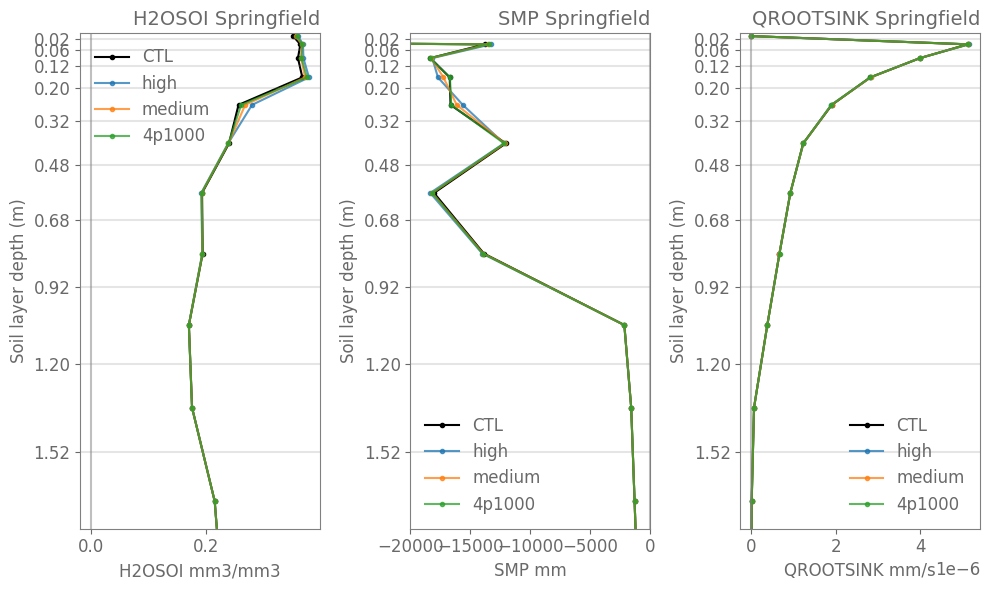

In [20]:
d_xlims = {'H2OSOI': False, 'SMP' : [-20e3,0],  'QROOTSINK' : False}
plot_abs_profiles(variables, d_xlims, d_ctl_cell, d_scen_cell, marker, d_units)

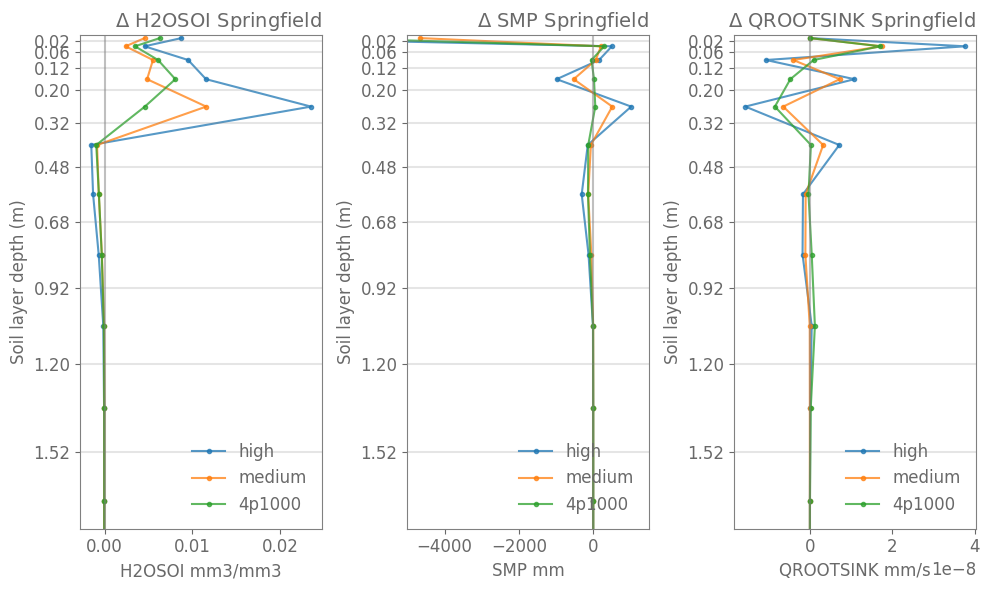

In [24]:
d_xlims = {'H2OSOI': False, 'SMP' : [-0.5e4,1.5e3], 'QROOTSINK' : False}
plot_delta_profiles(variables, d_xlims, d_delta_cell, marker, d_units)

### OLD

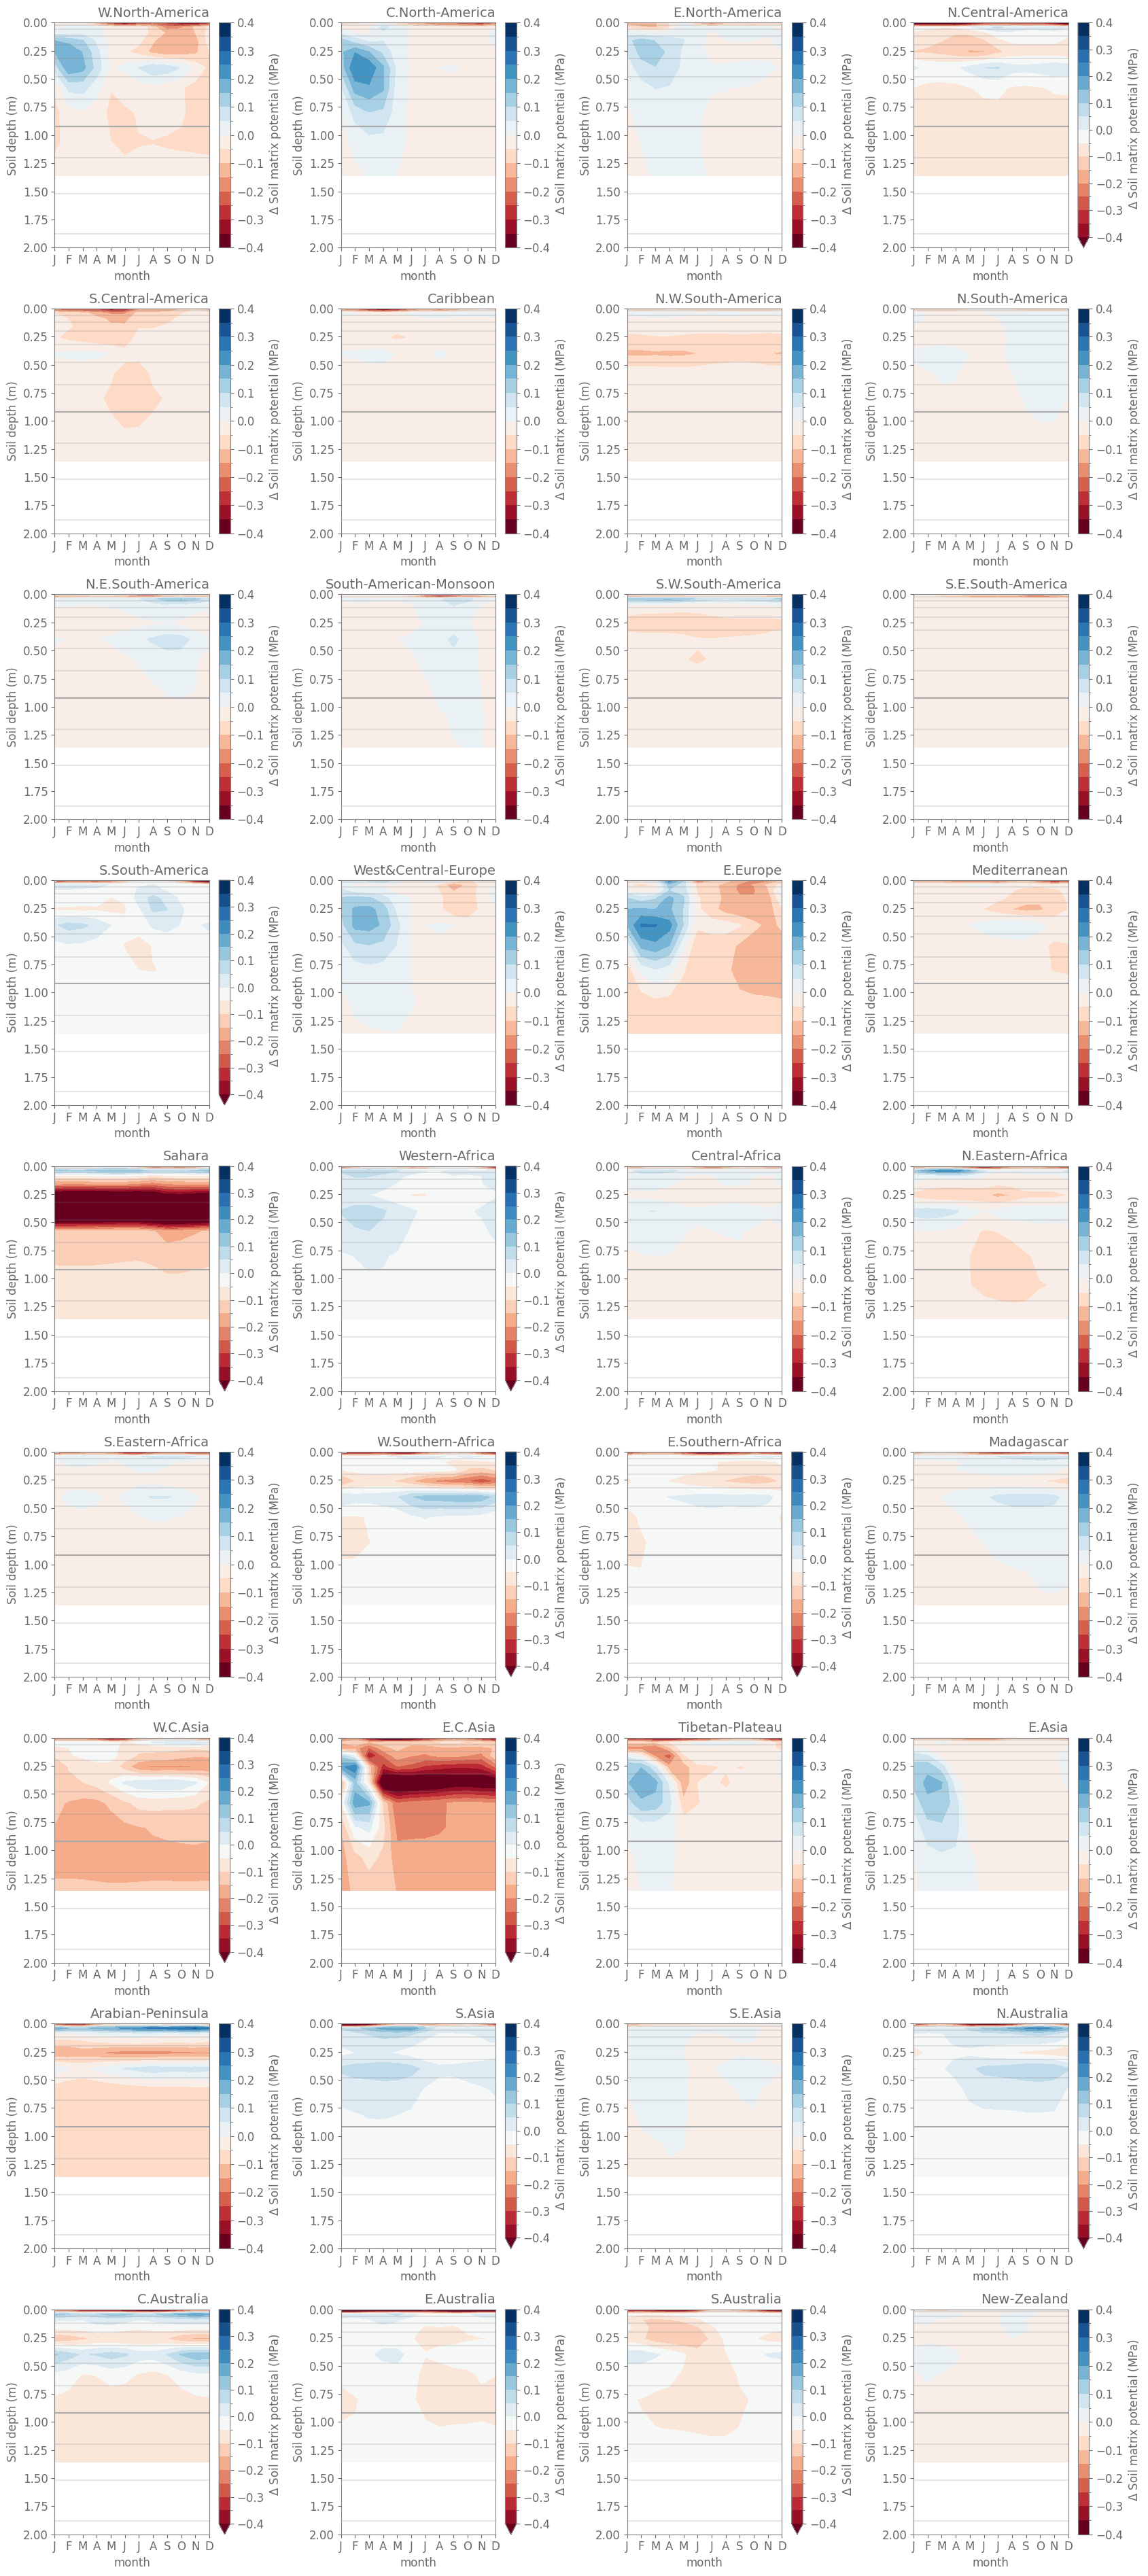

In [23]:
# prepare for plotting 
flag_plot_rootuptake = False

variable = 'SOILPSI'


# open regions dataset
da_regions = xr.open_dataset(procdir+'/postprocessing/pft_gridding/regional_means.'+variable+'.'+str(pft_int)+'..delta_change.nc')[variable]

da_regions_seasmean = da_regions.groupby('time.month').mean().squeeze()



fig, axes = plt.subplots(9,4,figsize=figsize)
axes = axes.flatten()

for i, region in enumerate(region_ids):
    
    ax = axes[i]

    region_name = regionmask.defined_regions.ar6.land[region].name
    region_abbrev = regionmask.defined_regions.ar6.land[region].abbrev

    
    levels =np.arange(-0.4,0.45,0.05)
    ticks =np.arange(-3,3.5,0.5)
    
    da_regions_seasmean.sel(region=region).plot.contourf(ax=ax, x='month', y='levsoi', cmap='RdBu', cbar_kwargs={'label':' $\Delta$ Soil matrix potential (MPa)'}, levels=levels)

    ax.hlines(levsoi_depth, 1,12, color='grey', alpha=0.2)
    ax.hlines(levsoi_depth[7],1,12, color='darkgrey', alpha=1)
    
    
    # plot QROOT
    if flag_plot_rootuptake: 
        levels_qroot = np.arange(0,2.75e-6,0.5e-6)
        cs = da_ctl_region_qroot_seasmean.sel(region=region).plot.contour(ax=ax,  x='month', y='levsoi', label='Root water uptake', levels=levels_qroot, linewidths=0.5, colors='k') #, colors='dimgray')
        ax.clabel(cs, inline=True, fontsize=10)

    ax.set_ylim([plotting_depth,0])
    ax.set_title(region_name, loc='right')
    ax.set_title(' ', loc='center')
    ax.set_ylabel('Soil depth (m)')
    ax.set_xticks(np.arange(1,13))
    ax.set_xticklabels(['J', 'F', 'M', 'A', 'M', 'J', 'J', 'A', 'S', 'O', 'N', 'D'])
    fig.tight_layout()